# Mask Convolutional Neural Network for Multi-level Hierarchical Classification

In [1]:
from deakin.edu.au.data import Cifar100, Stanford_Cars
import deakin.edu.au.models as models
import deakin.edu.au.metrics as metrics
from tensorflow.keras.utils import plot_model
import tensorflow as tf
from graphviz import Digraph
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from matplotlib.patches import Rectangle
import numpy as np
from sklearn.metrics import accuracy_score
from keras.callbacks import TensorBoard
from tensorflow.keras.applications import VGG19
import random
from tensorflow import keras


%load_ext autoreload
%autoreload 2
%load_ext tensorboard


2021-08-27 17:35:06.121808: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0


# Loading data

In [2]:
#Load dataset
dataset = Cifar100()
num_classes = [dataset.num_classes_l0, dataset.num_classes_l1, dataset.num_classes_l2]
u = dataset.draw_taxonomy()
u.view()

# Set variables
batch = 128
epochs = 100
# VGG-19
conv_base = 'vgg19'
learning_rate=1e-5
# NIN
# conv_base = 'nin'
# learning_rate=1e-3

early_stopping_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)
performance_callback = models.performance_callback(dataset.X_val, dataset.y_val, dataset.taxonomy)

checkpoint_filepath = '/tmp/checkpoint_new'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=False,
    monitor='val_loss',
    mode='min',
    save_best_only=True)


In [2]:
#Load dataset
dataset = Stanford_Cars(image_size=(64,64))
num_classes = [dataset.num_classes_l0, dataset.num_classes_l1, dataset.num_classes_l2]
u = dataset.draw_taxonomy()
u.view()

# Set variables
batch = 128
epochs = 100
# VGG-19
conv_base = 'vgg19'
learning_rate=1e-5
# NIN
# conv_base = 'nin'
# learning_rate=1e-3

early_stopping_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)
performance_callback = models.performance_callback(dataset.X_val, dataset.y_val, dataset.taxonomy)

checkpoint_filepath = '/tmp/checkpoint_new'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=False,
    monitor='val_loss',
    mode='min',
    save_best_only=True)



Preparing dataset..
Found 16185 files belonging to 1 classes.


2021-08-27 17:35:13.989127: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcuda.so.1
2021-08-27 17:35:14.056649: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:65:00.0 name: GeForce RTX 2080 Ti computeCapability: 7.5
coreClock: 1.545GHz coreCount: 68 deviceMemorySize: 10.75GiB deviceMemoryBandwidth: 573.69GiB/s
2021-08-27 17:35:14.056715: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
2021-08-27 17:35:14.061706: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublas.so.11
2021-08-27 17:35:14.061814: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublasLt.so.11
2021-08-27 17:35:14.064191: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcufft.

Found 16185 files belonging to 1 classes.


# Visualization

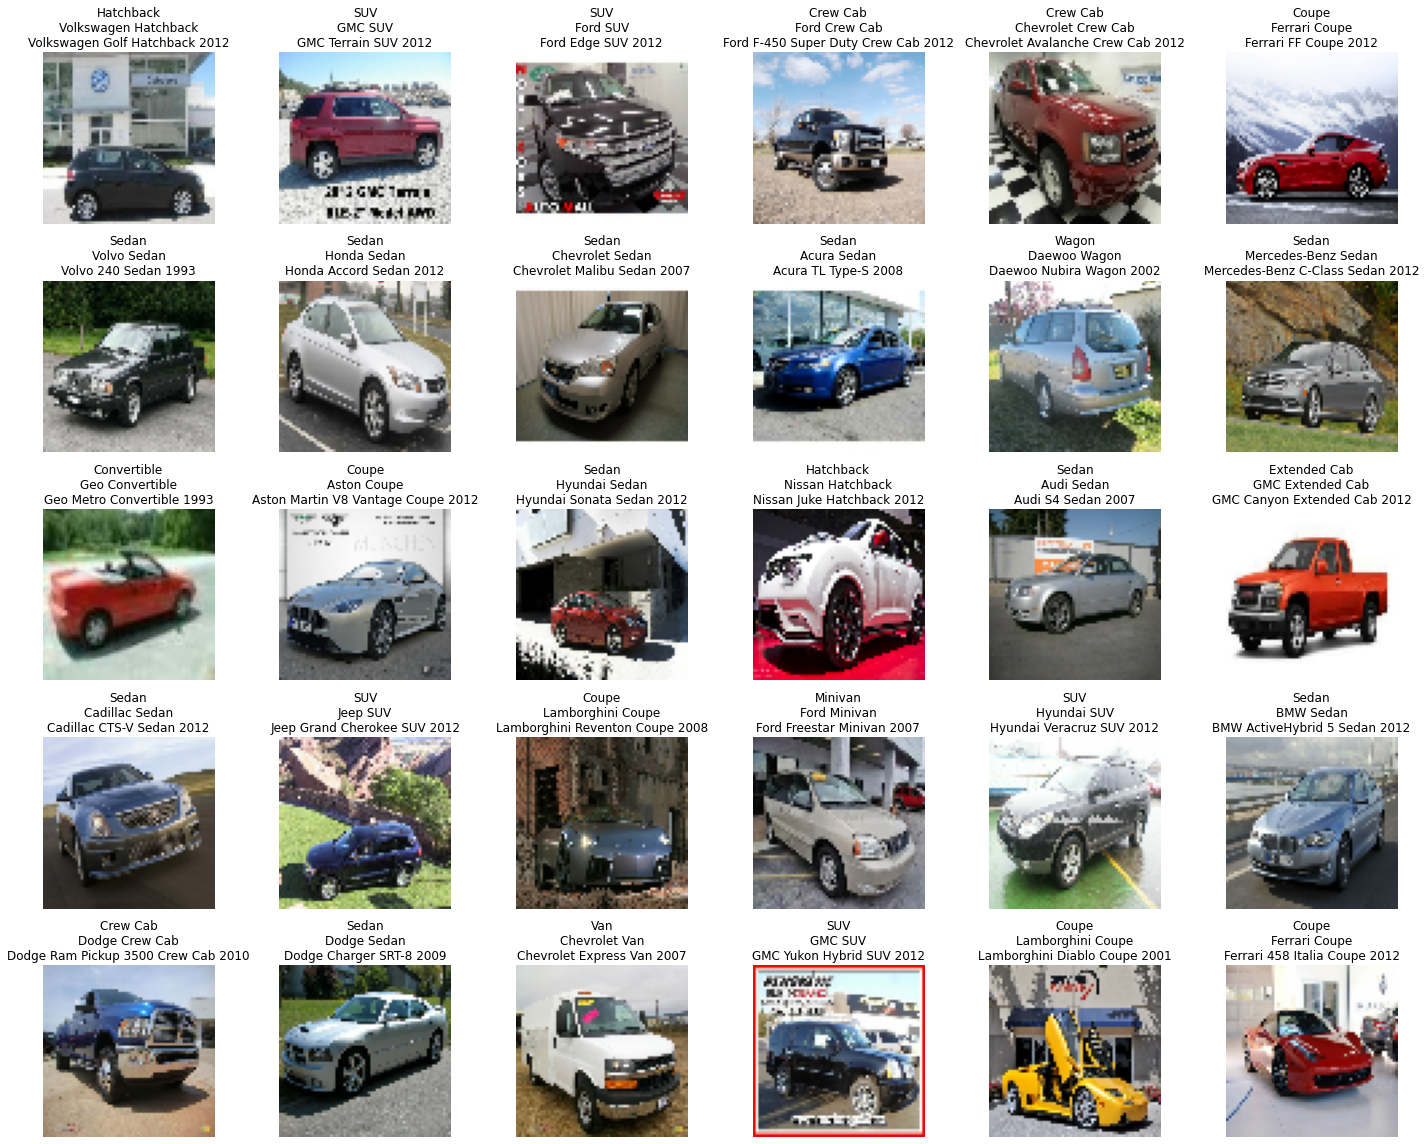

In [3]:
plt.figure(figsize=(20, 16))
for i in range(30):
    k = random.randint(0, len(dataset.X_train))
    y_l0 = dataset.labels[0][dataset.y_train[0][k][0]]
    y_l1 = dataset.labels[1][dataset.y_train[1][k][0]]
    y_l2 = dataset.labels[2][dataset.y_train[2][k][0]]

    ax = plt.subplot(5, 6, i + 1)
    plt.imshow(dataset.X_train[k])
    plt.title(y_l0 + "\n" + y_l1 + "\n" + y_l2)
    plt.axis("off")

plt.tight_layout() 
plt.show()

In [4]:
def learning_plots(history):
    plt.figure(figsize=(15,4))
    ax1 = plt.subplot(1, 2, 1)
    for l in history.history:
        if l == 'loss' or l == 'val_loss':  
            loss = history.history[l]
            plt.plot(range(1, len(loss) + 1), loss, label=l)

    plt.title('Training and validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    ax2 = plt.subplot(1, 2, 2)
    for k in history.history:
        if 'accuracy' in k:  
            loss = history.history[k]
            plt.plot(range(1, len(loss) + 1), loss, label=k)
    plt.title('Training and validation accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()


# Training all models

Model: "mnets"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
main_input (InputLayer)         [(None, 64, 64, 3)]  0                                            
__________________________________________________________________________________________________
conv_base0 (Functional)         (None, None, None, 5 20024384    main_input[0][0]                 
__________________________________________________________________________________________________
conv_base1 (Functional)         (None, None, None, 5 20024384    main_input[0][0]                 
__________________________________________________________________________________________________
conv_base2 (Functional)         (None, None, None, 5 20024384    main_input[0][0]                 
______________________________________________________________________________________________

2021-08-27 17:37:33.201820: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudnn.so.8
2021-08-27 17:37:33.640398: I tensorflow/stream_executor/cuda/cuda_dnn.cc:359] Loaded cuDNN version 8100
2021-08-27 17:37:34.349325: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublas.so.11
2021-08-27 17:37:34.746395: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublasLt.so.11
2021-08-27 17:37:38.745345: W tensorflow/core/common_runtime/bfc_allocator.cc:271] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.17GiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.


64/64 [==============================] - 25s 268ms/step - loss: 4.8842 - out_level_0_loss: 2.9064 - out_level_1_loss: 5.5814 - out_level_2_loss: 6.1648 - out_level_0_accuracy: 0.2386 - out_level_1_accuracy: 0.0151 - out_level_2_accuracy: 0.0043 - val_loss: 4.0559 - val_out_level_0_loss: 2.1636 - val_out_level_1_loss: 4.7261 - val_out_level_2_loss: 5.2781 - val_out_level_0_accuracy: 0.2540 - val_out_level_1_accuracy: 0.0256 - val_out_level_2_accuracy: 0.0076
----------------------------------------------------------------------------------------------------
epoch=1, Exact Match = 0.0000, accuracy level_0 = 0.2540, accuracy level_1 = 0.0256, accuracy level_2 = 0.0076, Consistency = 0.0000
----------------------------------------------------------------------------------------------------

Epoch 2/100
64/64 [==============================] - 14s 216ms/step - loss: 4.0457 - out_level_0_loss: 2.1340 - out_level_1_loss: 4.7251 - out_level_2_loss: 5.2781 - out_level_0_accuracy: 0.2615 - out_l

64/64 [==============================] - 14s 217ms/step - loss: 3.7074 - out_level_0_loss: 1.1339 - out_level_1_loss: 4.7109 - out_level_2_loss: 5.2776 - out_level_0_accuracy: 0.5874 - out_level_1_accuracy: 0.0270 - out_level_2_accuracy: 0.0083 - val_loss: 3.8388 - val_out_level_0_loss: 1.5283 - val_out_level_1_loss: 4.7106 - val_out_level_2_loss: 5.2776 - val_out_level_0_accuracy: 0.4488 - val_out_level_1_accuracy: 0.0264 - val_out_level_2_accuracy: 0.0076
----------------------------------------------------------------------------------------------------
epoch=11, Exact Match = 0.0000, accuracy level_0 = 0.4488, accuracy level_1 = 0.0264, accuracy level_2 = 0.0076, Consistency = 0.0000
----------------------------------------------------------------------------------------------------

Epoch 12/100
64/64 [==============================] - 14s 216ms/step - loss: 3.6581 - out_level_0_loss: 0.9874 - out_level_1_loss: 4.7094 - out_level_2_loss: 5.2776 - out_level_0_accuracy: 0.6417 - out

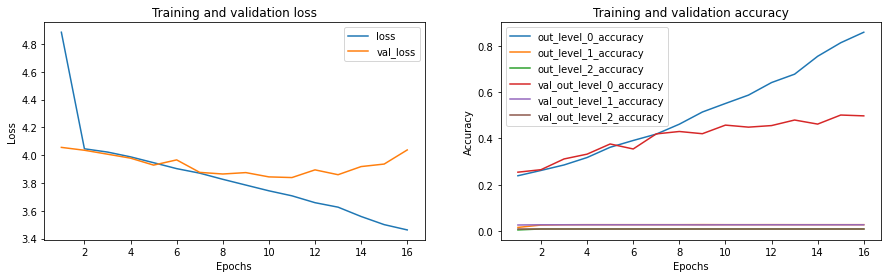

2021-08-27 17:41:58.252875: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: models/mnets_model/assets


In [5]:
# Create the model
mnets_model = models.get_mnets(num_classes, 
                               dataset.image_size, 
                               conv_base=conv_base,
                               learning_rate=learning_rate)
mnets_model.summary()
#train model
history_mnets_model = mnets_model.fit(dataset.X_train, 
                    dataset.y_train,
                    validation_data = (dataset.X_val, dataset.y_val), 
                    batch_size=batch, 
                    epochs=epochs,
                    callbacks=[performance_callback, early_stopping_callback]
                    )
plot_model(mnets_model)
learning_plots(history_mnets_model)
mnets_model.save("models/mnets_model")


In [6]:
mnets_model_pred = mnets_model.predict(dataset.X_test)
mnets_model_accuracy = metrics.get_top_k_taxonomical_accuracy(dataset.y_test, mnets_model_pred)
mnets_model_accuracy = [x * 100 for x in mnets_model_accuracy]


In [7]:
def get_potential_improvement(true_y, pred_y, taxo):
    
    pred_y = [np.argmax(x, axis=1) for x in pred_y]
    oracle_accuracy1 = [0] * len(pred_y)
    oracle_accuracy2 = [0] * len(pred_y)
    oracle_accuracy = [0] * len(pred_y)
    for i in range(len(pred_y)):
        for j in range(len(pred_y[0])):
            # check correctness
            if pred_y[i][j] == true_y[i][j][0]:
                continue
            else:
                # go left to right
                stop = False
                for z in range(i+1, len(pred_y)):
                    if pred_y[z][j] == true_y[z][j][0]:
                        oracle_accuracy[i] = oracle_accuracy[i] + 1
                        oracle_accuracy1[i] = oracle_accuracy1[i] + 1
                        stop = True
                        break
                #go right to left -- do not touch, complex code 
                if stop == False and i > 0:
                    parents = []
                    current = pred_y[i][j]
                    for z in reversed(range(i)):
                        m = taxo[z]
                        row = list(np.transpose(m)[current])
                        parent = row.index(1)
                        current = parent
                        parents.insert(0, parent)
                    for z in reversed(range(i)):
                        if pred_y[z][j] == true_y[z][j][0] and true_y[z][j][0] != parents[z]:
                            oracle_accuracy[i] = oracle_accuracy[i] + 1
                            oracle_accuracy2[i] = oracle_accuracy2[i] + 1
                            break
    
    print("Total improvement: ",oracle_accuracy)
    print("Left to right improvement: ",oracle_accuracy1)
    print("Right to left improvement: ",oracle_accuracy2)
    oracle_accuracy  = [x*100/len(mnets_model_pred[0]) for x in oracle_accuracy] 
    return oracle_accuracy


# Testings
# taxo = [[[1, 1, 0, 0, 0], [0, 0, 1, 1, 1]],
#             [[1, 1, 0, 0, 0, 0, 0, 0, 0], [0, 0, 1, 0, 0, 0, 0, 0, 0], [0, 0, 0, 1, 1, 1, 0, 0, 0],
#              [0, 0, 0, 0, 0, 0, 1, 1, 0], [0, 0, 0, 0, 0, 0, 0, 0, 1]]
#             ]
# pred = [np.array([0]), np.array([1]),np.array([2])]
# true_y = [np.array([[0]]), np.array([[0]]),np.array([[0]])]
# get_potential_improvement(pred, true_y, taxo)

# oracle_accuracy = get_potential_improvement(mnets_model_pred,
#                                             dataset.y_test, 
#                                             dataset.taxonomy)



Total improvement:  [57, 2184, 2769]
Left to right improvement:  [57, 49, 0]
Right to left improvement:  [0, 2135, 2769]


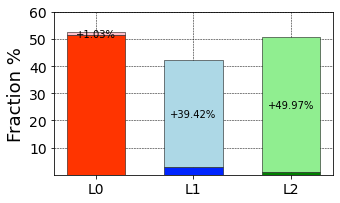

In [8]:
oracle_accuracy = get_potential_improvement(dataset.y_test, 
                                            mnets_model_pred,
                                            dataset.taxonomy)

labels = ['L0', 'L1', 'L2']
width  = 0.6
params = {'legend.fontsize': 10,
          'axes.labelsize': 18,
          'axes.titlesize': 11,
          'xtick.labelsize': 14,
          'ytick.labelsize': 14,
          'axes.titlepad': 12}
plt.rcParams.update(params)

fig, ax = plt.subplots(figsize=(5,3))
ax.set_axisbelow(True)
ax.bar(labels, mnets_model_accuracy, width, edgecolor = 'black', linewidth = 0.5, color=['#FF3400','#0025FF','#008000','#FFFD07'])
ax.bar(labels, oracle_accuracy, width,  bottom=mnets_model_accuracy, edgecolor = 'black', linewidth = 0.5, color=['#FFC0CB','#ADD8E6','#90EE90','#FFFEE0'])
ax.set_ylabel('Fraction %')
rects = ax.patches
labels = ["+%.2f" % i for i in oracle_accuracy]
labels = [x+"%" for x in labels]

heights = []
for imp, accuracy in zip(oracle_accuracy, mnets_model_accuracy):
    heights.append(accuracy+imp/2)
 

  
for rect, label, height in zip(rects, labels,heights):
    ax.text(rect.get_x() + rect.get_width() / 2, height-2, label,
            ha='center', va='bottom')

plt.yticks([10, 20, 30, 40, 50, 60, 70, 80, 90, 100])
# ax.set_yticks([0,2,4,6])
ax.set_ylim(0, 60)
plt.grid(color = 'black', linestyle = '--', linewidth = 0.5)

plt.savefig('plots/oracle.eps', bbox_inches = 'tight')
plt.show()

Model: "mout_model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
main_input (InputLayer)         [(None, 64, 64, 3)]  0                                            
__________________________________________________________________________________________________
vgg19 (Functional)              (None, None, None, 5 20024384    main_input[0][0]                 
__________________________________________________________________________________________________
flatten_3 (Flatten)             (None, 2048)         0           vgg19[0][0]                      
__________________________________________________________________________________________________
out_level_0 (Dense)             (None, 13)           26637       flatten_3[0][0]                  
_________________________________________________________________________________________

----------------------------------------------------------------------------------------------------
epoch=8, Exact Match = 0.0000, accuracy level_0 = 0.3124, accuracy level_1 = 0.0332, accuracy level_2 = 0.0072, Consistency = 0.0004
----------------------------------------------------------------------------------------------------

Epoch 9/100
64/64 [==============================] - 5s 81ms/step - loss: 3.7874 - out_level_0_loss: 1.8853 - out_level_1_loss: 4.3769 - out_level_2_loss: 5.1000 - out_level_0_accuracy: 0.3448 - out_level_1_accuracy: 0.0508 - out_level_2_accuracy: 0.0142 - val_loss: 3.7179 - val_out_level_0_loss: 1.8583 - val_out_level_1_loss: 4.2956 - val_out_level_2_loss: 4.9998 - val_out_level_0_accuracy: 0.3556 - val_out_level_1_accuracy: 0.0552 - val_out_level_2_accuracy: 0.0164
----------------------------------------------------------------------------------------------------
epoch=9, Exact Match = 0.0048, accuracy level_0 = 0.3556, accuracy level_1 = 0.0552, accura

64/64 [==============================] - 5s 81ms/step - loss: 1.5326 - out_level_0_loss: 0.5786 - out_level_1_loss: 1.7441 - out_level_2_loss: 2.2750 - out_level_0_accuracy: 0.7847 - out_level_1_accuracy: 0.4897 - out_level_2_accuracy: 0.3794 - val_loss: 3.3161 - val_out_level_0_loss: 1.7656 - val_out_level_1_loss: 3.8741 - val_out_level_2_loss: 4.3085 - val_out_level_0_accuracy: 0.5084 - val_out_level_1_accuracy: 0.1868 - val_out_level_2_accuracy: 0.1332
----------------------------------------------------------------------------------------------------
epoch=19, Exact Match = 0.0692, accuracy level_0 = 0.5084, accuracy level_1 = 0.1868, accuracy level_2 = 0.1332, Consistency = 0.3284
----------------------------------------------------------------------------------------------------

Epoch 20/100
64/64 [==============================] - 5s 81ms/step - loss: 1.2178 - out_level_0_loss: 0.4544 - out_level_1_loss: 1.3664 - out_level_2_loss: 1.8325 - out_level_0_accuracy: 0.8347 - out_lev

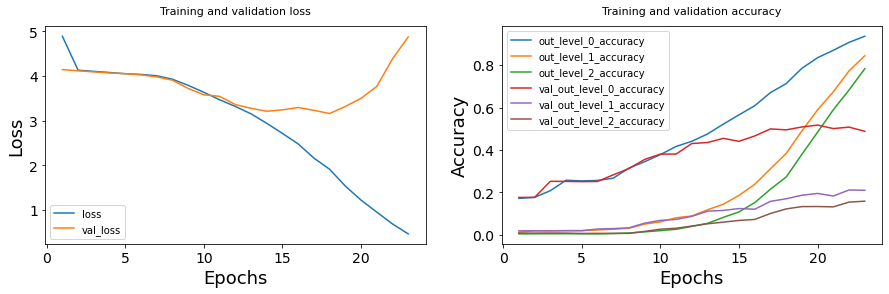

INFO:tensorflow:Assets written to: models/mout_model/assets


In [9]:
# Create the model
mout_model = models.get_mout_model(num_classes, 
                                   dataset.image_size, 
                                   conv_base=conv_base,
                                   learning_rate=learning_rate)
mout_model.summary()
#train model
history_mout_model = mout_model.fit(dataset.X_train, 
                    dataset.y_train,
                    validation_data = (dataset.X_val, dataset.y_val), 
                    batch_size=batch, 
                    epochs=epochs,
                    callbacks=[performance_callback, early_stopping_callback]
                    )
plot_model(mout_model)
learning_plots(history_mout_model)
mout_model.save("models/mout_model")


Model: "Model_BCNN1_reversed_False"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
main_input (InputLayer)      [(None, 64, 64, 3)]       0         
_________________________________________________________________
vgg19 (Functional)           (None, None, None, 512)   20024384  
_________________________________________________________________
flatten_4 (Flatten)          (None, 2048)              0         
_________________________________________________________________
out_level_0 (Dense)          (None, 13)                26637     
_________________________________________________________________
out_level_1 (Dense)          (None, 113)               1582      
_________________________________________________________________
out_level_2 (Dense)          (None, 196)               22344     
Total params: 20,074,947
Trainable params: 20,074,947
Non-trainable params: 0
____________________________

64/64 [==============================] - 5s 81ms/step - loss: 3.7577 - out_level_0_loss: 1.3145 - out_level_1_loss: 4.6813 - out_level_2_loss: 5.2773 - out_level_0_accuracy: 0.5281 - out_level_1_accuracy: 0.0508 - out_level_2_accuracy: 0.0083 - val_loss: 3.8346 - val_out_level_0_loss: 1.5475 - val_out_level_1_loss: 4.6789 - val_out_level_2_loss: 5.2773 - val_out_level_0_accuracy: 0.4652 - val_out_level_1_accuracy: 0.0500 - val_out_level_2_accuracy: 0.0076
----------------------------------------------------------------------------------------------------
epoch=9, Exact Match = 0.0000, accuracy level_0 = 0.4652, accuracy level_1 = 0.0500, accuracy level_2 = 0.0076, Consistency = 0.0000
----------------------------------------------------------------------------------------------------

Epoch 10/100
64/64 [==============================] - 5s 81ms/step - loss: 3.7038 - out_level_0_loss: 1.1607 - out_level_1_loss: 4.6736 - out_level_2_loss: 5.2772 - out_level_0_accuracy: 0.5802 - out_leve

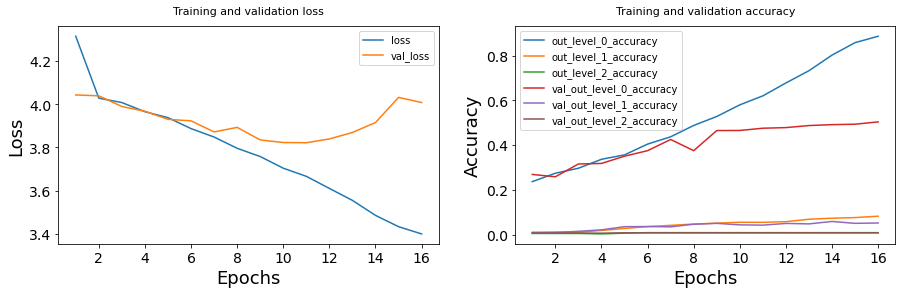

INFO:tensorflow:Assets written to: models/BCNN1_model/assets


In [10]:
# Create the model
BCNN1_model = models.get_BCNN1(num_classes, 
                               dataset.image_size, 
                               conv_base=conv_base,
                               learning_rate=learning_rate)
BCNN1_model.summary()
#train model
history_BCNN1_model = BCNN1_model.fit(dataset.X_train, 
                    dataset.y_train,
                    validation_data = (dataset.X_val, dataset.y_val), 
                    batch_size=batch, 
                    epochs=epochs,
                    callbacks=[performance_callback, early_stopping_callback]
                    )
plot_model(BCNN1_model)
learning_plots(history_BCNN1_model)
BCNN1_model.save("models/BCNN1_model")


Model: "Model_BCNN1_reversed_True"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
main_input (InputLayer)      [(None, 64, 64, 3)]       0         
_________________________________________________________________
vgg19 (Functional)           (None, None, None, 512)   20024384  
_________________________________________________________________
flatten_5 (Flatten)          (None, 2048)              0         
_________________________________________________________________
out_level_2 (Dense)          (None, 196)               401604    
_________________________________________________________________
out_level_1 (Dense)          (None, 113)               22261     
_________________________________________________________________
out_level_0 (Dense)          (None, 13)                1482      
Total params: 20,449,731
Trainable params: 20,449,731
Non-trainable params: 0
_____________________________

64/64 [==============================] - 5s 80ms/step - loss: 4.1574 - out_level_0_loss: 2.4929 - out_level_1_loss: 4.7016 - out_level_2_loss: 5.2777 - out_level_0_accuracy: 0.1764 - out_level_1_accuracy: 0.0278 - out_level_2_accuracy: 0.0083 - val_loss: 4.1562 - val_out_level_0_loss: 2.4900 - val_out_level_1_loss: 4.7008 - val_out_level_2_loss: 5.2777 - val_out_level_0_accuracy: 0.1764 - val_out_level_1_accuracy: 0.0256 - val_out_level_2_accuracy: 0.0076
----------------------------------------------------------------------------------------------------
epoch=9, Exact Match = 0.0000, accuracy level_0 = 0.1764, accuracy level_1 = 0.0256, accuracy level_2 = 0.0076, Consistency = 0.0000
----------------------------------------------------------------------------------------------------

Epoch 10/100
64/64 [==============================] - 5s 80ms/step - loss: 4.1537 - out_level_0_loss: 2.4847 - out_level_1_loss: 4.6987 - out_level_2_loss: 5.2777 - out_level_0_accuracy: 0.1764 - out_leve

64/64 [==============================] - 5s 80ms/step - loss: 4.1235 - out_level_0_loss: 2.4179 - out_level_1_loss: 4.6753 - out_level_2_loss: 5.2772 - out_level_0_accuracy: 0.1764 - out_level_1_accuracy: 0.0278 - out_level_2_accuracy: 0.0083 - val_loss: 4.1233 - val_out_level_0_loss: 2.4172 - val_out_level_1_loss: 4.6755 - val_out_level_2_loss: 5.2773 - val_out_level_0_accuracy: 0.1764 - val_out_level_1_accuracy: 0.0256 - val_out_level_2_accuracy: 0.0076
----------------------------------------------------------------------------------------------------
epoch=19, Exact Match = 0.0000, accuracy level_0 = 0.1764, accuracy level_1 = 0.0256, accuracy level_2 = 0.0076, Consistency = 0.0000
----------------------------------------------------------------------------------------------------

Epoch 20/100
64/64 [==============================] - 5s 80ms/step - loss: 4.1204 - out_level_0_loss: 2.4112 - out_level_1_loss: 4.6729 - out_level_2_loss: 5.2772 - out_level_0_accuracy: 0.1764 - out_lev

64/64 [==============================] - 5s 80ms/step - loss: 4.0957 - out_level_0_loss: 2.3570 - out_level_1_loss: 4.6534 - out_level_2_loss: 5.2768 - out_level_0_accuracy: 0.1764 - out_level_1_accuracy: 0.0278 - out_level_2_accuracy: 0.0083 - val_loss: 4.0965 - val_out_level_0_loss: 2.3582 - val_out_level_1_loss: 4.6544 - val_out_level_2_loss: 5.2769 - val_out_level_0_accuracy: 0.1764 - val_out_level_1_accuracy: 0.0256 - val_out_level_2_accuracy: 0.0076
----------------------------------------------------------------------------------------------------
epoch=29, Exact Match = 0.0000, accuracy level_0 = 0.1764, accuracy level_1 = 0.0256, accuracy level_2 = 0.0076, Consistency = 0.0000
----------------------------------------------------------------------------------------------------

Epoch 30/100
64/64 [==============================] - 5s 80ms/step - loss: 4.0932 - out_level_0_loss: 2.3516 - out_level_1_loss: 4.6514 - out_level_2_loss: 5.2767 - out_level_0_accuracy: 0.1764 - out_lev

64/64 [==============================] - 5s 80ms/step - loss: 4.0733 - out_level_0_loss: 2.3081 - out_level_1_loss: 4.6353 - out_level_2_loss: 5.2764 - out_level_0_accuracy: 0.2548 - out_level_1_accuracy: 0.0278 - out_level_2_accuracy: 0.0083 - val_loss: 4.0750 - val_out_level_0_loss: 2.3112 - val_out_level_1_loss: 4.6373 - val_out_level_2_loss: 5.2766 - val_out_level_0_accuracy: 0.2508 - val_out_level_1_accuracy: 0.0256 - val_out_level_2_accuracy: 0.0076
----------------------------------------------------------------------------------------------------
epoch=39, Exact Match = 0.0000, accuracy level_0 = 0.2508, accuracy level_1 = 0.0256, accuracy level_2 = 0.0076, Consistency = 0.0000
----------------------------------------------------------------------------------------------------

Epoch 40/100
64/64 [==============================] - 5s 80ms/step - loss: 4.0713 - out_level_0_loss: 2.3038 - out_level_1_loss: 4.6337 - out_level_2_loss: 5.2764 - out_level_0_accuracy: 0.2548 - out_lev

64/64 [==============================] - 5s 80ms/step - loss: 4.0553 - out_level_0_loss: 2.2693 - out_level_1_loss: 4.6205 - out_level_2_loss: 5.2760 - out_level_0_accuracy: 0.2548 - out_level_1_accuracy: 0.0278 - out_level_2_accuracy: 0.0083 - val_loss: 4.0579 - val_out_level_0_loss: 2.2740 - val_out_level_1_loss: 4.6233 - val_out_level_2_loss: 5.2763 - val_out_level_0_accuracy: 0.2508 - val_out_level_1_accuracy: 0.0256 - val_out_level_2_accuracy: 0.0076
----------------------------------------------------------------------------------------------------
epoch=49, Exact Match = 0.0000, accuracy level_0 = 0.2508, accuracy level_1 = 0.0256, accuracy level_2 = 0.0076, Consistency = 0.0000
----------------------------------------------------------------------------------------------------

Epoch 50/100
64/64 [==============================] - 5s 80ms/step - loss: 4.0537 - out_level_0_loss: 2.2659 - out_level_1_loss: 4.6192 - out_level_2_loss: 5.2760 - out_level_0_accuracy: 0.2548 - out_lev

64/64 [==============================] - 5s 80ms/step - loss: 4.0410 - out_level_0_loss: 2.2389 - out_level_1_loss: 4.6085 - out_level_2_loss: 5.2757 - out_level_0_accuracy: 0.2548 - out_level_1_accuracy: 0.0278 - out_level_2_accuracy: 0.0083 - val_loss: 4.0443 - val_out_level_0_loss: 2.2450 - val_out_level_1_loss: 4.6121 - val_out_level_2_loss: 5.2760 - val_out_level_0_accuracy: 0.2508 - val_out_level_1_accuracy: 0.0256 - val_out_level_2_accuracy: 0.0076
----------------------------------------------------------------------------------------------------
epoch=59, Exact Match = 0.0000, accuracy level_0 = 0.2508, accuracy level_1 = 0.0256, accuracy level_2 = 0.0076, Consistency = 0.0000
----------------------------------------------------------------------------------------------------

Epoch 60/100
64/64 [==============================] - 5s 80ms/step - loss: 4.0398 - out_level_0_loss: 2.2362 - out_level_1_loss: 4.6074 - out_level_2_loss: 5.2757 - out_level_0_accuracy: 0.2548 - out_lev

64/64 [==============================] - 5s 80ms/step - loss: 4.0298 - out_level_0_loss: 2.2153 - out_level_1_loss: 4.5988 - out_level_2_loss: 5.2754 - out_level_0_accuracy: 0.2548 - out_level_1_accuracy: 0.0278 - out_level_2_accuracy: 0.0083 - val_loss: 4.0338 - val_out_level_0_loss: 2.2226 - val_out_level_1_loss: 4.6031 - val_out_level_2_loss: 5.2758 - val_out_level_0_accuracy: 0.2508 - val_out_level_1_accuracy: 0.0256 - val_out_level_2_accuracy: 0.0076
----------------------------------------------------------------------------------------------------
epoch=69, Exact Match = 0.0000, accuracy level_0 = 0.2508, accuracy level_1 = 0.0256, accuracy level_2 = 0.0076, Consistency = 0.0000
----------------------------------------------------------------------------------------------------

Epoch 70/100
64/64 [==============================] - 5s 80ms/step - loss: 4.0289 - out_level_0_loss: 2.2132 - out_level_1_loss: 4.5980 - out_level_2_loss: 5.2754 - out_level_0_accuracy: 0.2548 - out_lev

64/64 [==============================] - 5s 80ms/step - loss: 4.0212 - out_level_0_loss: 2.1972 - out_level_1_loss: 4.5912 - out_level_2_loss: 5.2751 - out_level_0_accuracy: 0.2548 - out_level_1_accuracy: 0.0278 - out_level_2_accuracy: 0.0083 - val_loss: 4.0257 - val_out_level_0_loss: 2.2056 - val_out_level_1_loss: 4.5960 - val_out_level_2_loss: 5.2756 - val_out_level_0_accuracy: 0.2508 - val_out_level_1_accuracy: 0.0256 - val_out_level_2_accuracy: 0.0076
----------------------------------------------------------------------------------------------------
epoch=79, Exact Match = 0.0000, accuracy level_0 = 0.2508, accuracy level_1 = 0.0256, accuracy level_2 = 0.0076, Consistency = 0.0000
----------------------------------------------------------------------------------------------------

Epoch 80/100
64/64 [==============================] - 5s 80ms/step - loss: 4.0204 - out_level_0_loss: 2.1956 - out_level_1_loss: 4.5905 - out_level_2_loss: 5.2751 - out_level_0_accuracy: 0.2548 - out_lev

64/64 [==============================] - 5s 80ms/step - loss: 4.0145 - out_level_0_loss: 2.1836 - out_level_1_loss: 4.5852 - out_level_2_loss: 5.2749 - out_level_0_accuracy: 0.2548 - out_level_1_accuracy: 0.0278 - out_level_2_accuracy: 0.0083 - val_loss: 4.0197 - val_out_level_0_loss: 2.1930 - val_out_level_1_loss: 4.5906 - val_out_level_2_loss: 5.2754 - val_out_level_0_accuracy: 0.2508 - val_out_level_1_accuracy: 0.0256 - val_out_level_2_accuracy: 0.0076
----------------------------------------------------------------------------------------------------
epoch=89, Exact Match = 0.0000, accuracy level_0 = 0.2508, accuracy level_1 = 0.0256, accuracy level_2 = 0.0076, Consistency = 0.0000
----------------------------------------------------------------------------------------------------

Epoch 90/100
64/64 [==============================] - 5s 80ms/step - loss: 4.0140 - out_level_0_loss: 2.1824 - out_level_1_loss: 4.5846 - out_level_2_loss: 5.2749 - out_level_0_accuracy: 0.2548 - out_lev

64/64 [==============================] - 5s 80ms/step - loss: 4.0096 - out_level_0_loss: 2.1735 - out_level_1_loss: 4.5805 - out_level_2_loss: 5.2747 - out_level_0_accuracy: 0.2548 - out_level_1_accuracy: 0.0278 - out_level_2_accuracy: 0.0083 - val_loss: 4.0152 - val_out_level_0_loss: 2.1838 - val_out_level_1_loss: 4.5865 - val_out_level_2_loss: 5.2752 - val_out_level_0_accuracy: 0.2508 - val_out_level_1_accuracy: 0.0256 - val_out_level_2_accuracy: 0.0076
----------------------------------------------------------------------------------------------------
epoch=99, Exact Match = 0.0000, accuracy level_0 = 0.2508, accuracy level_1 = 0.0256, accuracy level_2 = 0.0076, Consistency = 0.0000
----------------------------------------------------------------------------------------------------

Epoch 100/100
64/64 [==============================] - 5s 80ms/step - loss: 4.0091 - out_level_0_loss: 2.1726 - out_level_1_loss: 4.5801 - out_level_2_loss: 5.2747 - out_level_0_accuracy: 0.2548 - out_le

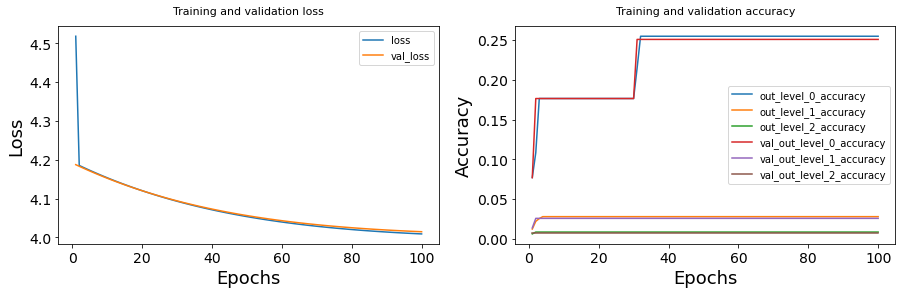

INFO:tensorflow:Assets written to: models/BCNN1_reversed_model/assets


In [11]:
# Create the model
BCNN1_reversed_model = models.get_BCNN1(num_classes, 
                                        dataset.image_size, 
                                        reverse=True, 
                                        conv_base=conv_base, 
                                        learning_rate=learning_rate)
BCNN1_reversed_model.summary()
#train model
history_BCNN1_reversed_model = BCNN1_reversed_model.fit(dataset.X_train, 
                    dataset.y_train,
                    validation_data = (dataset.X_val, dataset.y_val), 
                    batch_size=batch, 
                    epochs=epochs,
                    callbacks=[performance_callback, early_stopping_callback]
                    )
plot_model(BCNN1_reversed_model)
learning_plots(history_BCNN1_reversed_model)
BCNN1_reversed_model.save("models/BCNN1_reversed_model")


Model: "Model_BCNN2_reversed_False"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
main_input (InputLayer)         [(None, 64, 64, 3)]  0                                            
__________________________________________________________________________________________________
vgg19 (Functional)              (None, None, None, 5 20024384    main_input[0][0]                 
__________________________________________________________________________________________________
flatten_6 (Flatten)             (None, 2048)         0           vgg19[0][0]                      
__________________________________________________________________________________________________
logits_level_0 (Dense)          (None, 13)           26637       flatten_6[0][0]                  
_________________________________________________________________________

64/64 [==============================] - 5s 81ms/step - loss: 3.8668 - out_level_0_loss: 1.7973 - out_level_1_loss: 4.6731 - out_level_2_loss: 5.1300 - out_level_0_accuracy: 0.3899 - out_level_1_accuracy: 0.0227 - out_level_2_accuracy: 0.0108 - val_loss: 3.8641 - val_out_level_0_loss: 1.7947 - val_out_level_1_loss: 4.7028 - val_out_level_2_loss: 5.0949 - val_out_level_0_accuracy: 0.3940 - val_out_level_1_accuracy: 0.0120 - val_out_level_2_accuracy: 0.0128
----------------------------------------------------------------------------------------------------
epoch=8, Exact Match = 0.0000, accuracy level_0 = 0.3940, accuracy level_1 = 0.0120, accuracy level_2 = 0.0128, Consistency = 0.0112
----------------------------------------------------------------------------------------------------

Epoch 9/100
64/64 [==============================] - 5s 80ms/step - loss: 3.7834 - out_level_0_loss: 1.6934 - out_level_1_loss: 4.6372 - out_level_2_loss: 5.0196 - out_level_0_accuracy: 0.4164 - out_level

64/64 [==============================] - 5s 81ms/step - loss: 2.6164 - out_level_0_loss: 0.7370 - out_level_1_loss: 3.4828 - out_level_2_loss: 3.6294 - out_level_0_accuracy: 0.7414 - out_level_1_accuracy: 0.2027 - out_level_2_accuracy: 0.1444 - val_loss: 3.5813 - val_out_level_0_loss: 2.0322 - val_out_level_1_loss: 4.2867 - val_out_level_2_loss: 4.4250 - val_out_level_0_accuracy: 0.4588 - val_out_level_1_accuracy: 0.1076 - val_out_level_2_accuracy: 0.0636
----------------------------------------------------------------------------------------------------
epoch=18, Exact Match = 0.0252, accuracy level_0 = 0.4588, accuracy level_1 = 0.1076, accuracy level_2 = 0.0636, Consistency = 0.1964
----------------------------------------------------------------------------------------------------

Epoch 19/100
64/64 [==============================] - 5s 81ms/step - loss: 2.4872 - out_level_0_loss: 0.6879 - out_level_1_loss: 3.3142 - out_level_2_loss: 3.4595 - out_level_0_accuracy: 0.7663 - out_lev

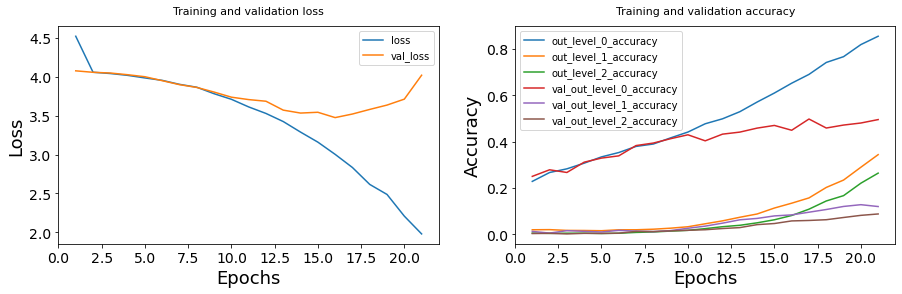

INFO:tensorflow:Assets written to: models/BCNN2_model/assets


In [12]:
# Create the model
BCNN2_model = models.get_BCNN2(num_classes, 
                               dataset.image_size, 
                               conv_base=conv_base, 
                               learning_rate=learning_rate)
BCNN2_model.summary()
#train model
history_BCNN2_model = BCNN2_model.fit(dataset.X_train, 
                    dataset.y_train,
                    validation_data = (dataset.X_val, dataset.y_val), 
                    batch_size=batch, 
                    epochs=epochs,
                    callbacks=[performance_callback, early_stopping_callback]
                    )
plot_model(BCNN2_model)
learning_plots(history_BCNN2_model)
BCNN2_model.save("models/BCNN2_model")


Model: "Model_BCNN2_reversed_True"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
main_input (InputLayer)         [(None, 64, 64, 3)]  0                                            
__________________________________________________________________________________________________
vgg19 (Functional)              (None, None, None, 5 20024384    main_input[0][0]                 
__________________________________________________________________________________________________
flatten_7 (Flatten)             (None, 2048)         0           vgg19[0][0]                      
__________________________________________________________________________________________________
logits_level_2 (Dense)          (None, 196)          401604      flatten_7[0][0]                  
__________________________________________________________________________

64/64 [==============================] - 5s 81ms/step - loss: 3.8368 - out_level_0_loss: 1.8312 - out_level_1_loss: 4.4229 - out_level_2_loss: 5.2563 - out_level_0_accuracy: 0.3685 - out_level_1_accuracy: 0.0562 - out_level_2_accuracy: 0.0122 - val_loss: 3.8149 - val_out_level_0_loss: 1.8294 - val_out_level_1_loss: 4.3828 - val_out_level_2_loss: 5.2324 - val_out_level_0_accuracy: 0.3508 - val_out_level_1_accuracy: 0.0572 - val_out_level_2_accuracy: 0.0100
----------------------------------------------------------------------------------------------------
epoch=8, Exact Match = 0.0000, accuracy level_0 = 0.3508, accuracy level_1 = 0.0572, accuracy level_2 = 0.0100, Consistency = 0.0084
----------------------------------------------------------------------------------------------------

Epoch 9/100
64/64 [==============================] - 5s 81ms/step - loss: 3.7533 - out_level_0_loss: 1.7621 - out_level_1_loss: 4.3133 - out_level_2_loss: 5.1844 - out_level_0_accuracy: 0.3858 - out_level

64/64 [==============================] - 5s 81ms/step - loss: 2.1558 - out_level_0_loss: 0.7341 - out_level_1_loss: 2.4428 - out_level_2_loss: 3.2905 - out_level_0_accuracy: 0.7328 - out_level_1_accuracy: 0.3367 - out_level_2_accuracy: 0.2132 - val_loss: 3.6528 - val_out_level_0_loss: 2.1881 - val_out_level_1_loss: 4.1170 - val_out_level_2_loss: 4.6532 - val_out_level_0_accuracy: 0.4464 - val_out_level_1_accuracy: 0.1360 - val_out_level_2_accuracy: 0.0720
----------------------------------------------------------------------------------------------------
epoch=18, Exact Match = 0.0280, accuracy level_0 = 0.4464, accuracy level_1 = 0.1360, accuracy level_2 = 0.0720, Consistency = 0.2244
----------------------------------------------------------------------------------------------------

Epoch 19/100
64/64 [==============================] - 5s 81ms/step - loss: 1.8835 - out_level_0_loss: 0.6325 - out_level_1_loss: 2.1126 - out_level_2_loss: 2.9055 - out_level_0_accuracy: 0.7709 - out_lev

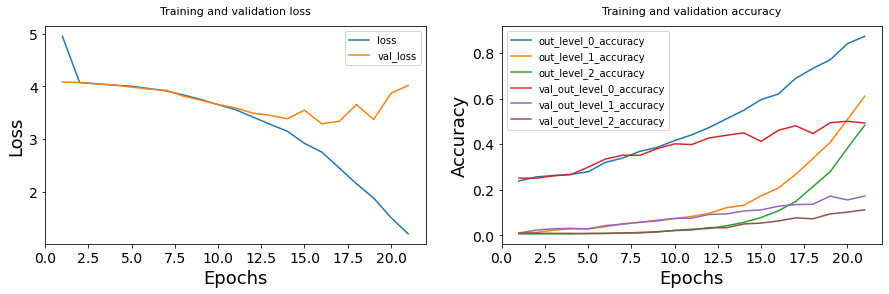

INFO:tensorflow:Assets written to: models/BCNN2_reversed_model/assets


In [13]:
# Create the model
BCNN2_reversed_model = models.get_BCNN2(num_classes, 
                                        dataset.image_size, 
                                        reverse=True, 
                                        conv_base=conv_base,
                                        learning_rate=learning_rate)
BCNN2_reversed_model.summary()
#train model
history_BCNN2_reversed_model = BCNN2_reversed_model.fit(dataset.X_train, 
                    dataset.y_train,
                    validation_data = (dataset.X_val, dataset.y_val), 
                    batch_size=batch, 
                    epochs=epochs,
                    callbacks=[performance_callback, early_stopping_callback]
                    )
plot_model(BCNN2_reversed_model)
learning_plots(history_BCNN2_reversed_model)
BCNN2_reversed_model.save("models/BCNN2_reversed_model")


Model: "MLPH_model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
main_input (InputLayer)         [(None, 64, 64, 3)]  0                                            
__________________________________________________________________________________________________
model (Functional)              [(None, None, None,  17664576    main_input[0][0]                 
__________________________________________________________________________________________________
flatten_8 (Flatten)             (None, 8192)         0           model[0][0]                      
__________________________________________________________________________________________________
flatten_9 (Flatten)             (None, 8192)         0           model[0][1]                      
_________________________________________________________________________________________

64/64 [==============================] - 5s 81ms/step - loss: 425.5706 - out_level_0_loss: 297.9499 - out_level_1_loss: 475.0002 - out_level_2_loss: 503.7615 - out_level_0_accuracy: 0.1133 - out_level_1_accuracy: 0.0114 - out_level_2_accuracy: 0.0059 - val_loss: 350.6224 - val_out_level_0_loss: 247.4829 - val_out_level_1_loss: 390.9795 - val_out_level_2_loss: 413.4049 - val_out_level_0_accuracy: 0.1156 - val_out_level_1_accuracy: 0.0108 - val_out_level_2_accuracy: 0.0064
----------------------------------------------------------------------------------------------------
epoch=5, Exact Match = 0.0000, accuracy level_0 = 0.1156, accuracy level_1 = 0.0108, accuracy level_2 = 0.0064, Consistency = 0.0012
----------------------------------------------------------------------------------------------------

Epoch 6/100
64/64 [==============================] - 5s 81ms/step - loss: 282.2094 - out_level_0_loss: 196.7132 - out_level_1_loss: 315.2272 - out_level_2_loss: 334.6879 - out_level_0_accu

64/64 [==============================] - 5s 81ms/step - loss: 18.7297 - out_level_0_loss: 13.3038 - out_level_1_loss: 21.1526 - out_level_2_loss: 21.7327 - out_level_0_accuracy: 0.1081 - out_level_1_accuracy: 0.0093 - out_level_2_accuracy: 0.0054 - val_loss: 17.9517 - val_out_level_0_loss: 12.8595 - val_out_level_1_loss: 19.5955 - val_out_level_2_loss: 21.4000 - val_out_level_0_accuracy: 0.1008 - val_out_level_1_accuracy: 0.0100 - val_out_level_2_accuracy: 0.0052
----------------------------------------------------------------------------------------------------
epoch=15, Exact Match = 0.0000, accuracy level_0 = 0.1008, accuracy level_1 = 0.0100, accuracy level_2 = 0.0052, Consistency = 0.0004
----------------------------------------------------------------------------------------------------

Epoch 16/100
64/64 [==============================] - 5s 81ms/step - loss: 15.2791 - out_level_0_loss: 10.8134 - out_level_1_loss: 17.2332 - out_level_2_loss: 17.7907 - out_level_0_accuracy: 0.10

64/64 [==============================] - 5s 81ms/step - loss: 6.0589 - out_level_0_loss: 3.9730 - out_level_1_loss: 6.8601 - out_level_2_loss: 7.3436 - out_level_0_accuracy: 0.1195 - out_level_1_accuracy: 0.0123 - out_level_2_accuracy: 0.0060 - val_loss: 6.3150 - val_out_level_0_loss: 4.2896 - val_out_level_1_loss: 6.9184 - val_out_level_2_loss: 7.7370 - val_out_level_0_accuracy: 0.1236 - val_out_level_1_accuracy: 0.0108 - val_out_level_2_accuracy: 0.0060
----------------------------------------------------------------------------------------------------
epoch=25, Exact Match = 0.0000, accuracy level_0 = 0.1236, accuracy level_1 = 0.0108, accuracy level_2 = 0.0060, Consistency = 0.0012
----------------------------------------------------------------------------------------------------

Epoch 26/100
64/64 [==============================] - 5s 81ms/step - loss: 5.7992 - out_level_0_loss: 3.7715 - out_level_1_loss: 6.5738 - out_level_2_loss: 7.0522 - out_level_0_accuracy: 0.1218 - out_lev

64/64 [==============================] - 5s 81ms/step - loss: 4.7404 - out_level_0_loss: 2.9616 - out_level_1_loss: 5.3676 - out_level_2_loss: 5.8919 - out_level_0_accuracy: 0.1568 - out_level_1_accuracy: 0.0177 - out_level_2_accuracy: 0.0053 - val_loss: 4.8796 - val_out_level_0_loss: 3.1192 - val_out_level_1_loss: 5.4480 - val_out_level_2_loss: 6.0716 - val_out_level_0_accuracy: 0.1500 - val_out_level_1_accuracy: 0.0160 - val_out_level_2_accuracy: 0.0060
----------------------------------------------------------------------------------------------------
epoch=35, Exact Match = 0.0000, accuracy level_0 = 0.1500, accuracy level_1 = 0.0160, accuracy level_2 = 0.0060, Consistency = 0.0008
----------------------------------------------------------------------------------------------------

Epoch 36/100
64/64 [==============================] - 5s 81ms/step - loss: 4.6862 - out_level_0_loss: 2.9185 - out_level_1_loss: 5.3080 - out_level_2_loss: 5.8321 - out_level_0_accuracy: 0.1616 - out_lev

64/64 [==============================] - 5s 80ms/step - loss: 4.4099 - out_level_0_loss: 2.6991 - out_level_1_loss: 4.9935 - out_level_2_loss: 5.5371 - out_level_0_accuracy: 0.2097 - out_level_1_accuracy: 0.0209 - out_level_2_accuracy: 0.0092 - val_loss: 4.5208 - val_out_level_0_loss: 2.8186 - val_out_level_1_loss: 5.0964 - val_out_level_2_loss: 5.6474 - val_out_level_0_accuracy: 0.1932 - val_out_level_1_accuracy: 0.0172 - val_out_level_2_accuracy: 0.0068
----------------------------------------------------------------------------------------------------
epoch=45, Exact Match = 0.0000, accuracy level_0 = 0.1932, accuracy level_1 = 0.0172, accuracy level_2 = 0.0068, Consistency = 0.0012
----------------------------------------------------------------------------------------------------

Epoch 46/100
64/64 [==============================] - 5s 80ms/step - loss: 4.3925 - out_level_0_loss: 2.6850 - out_level_1_loss: 4.9740 - out_level_2_loss: 5.5186 - out_level_0_accuracy: 0.2108 - out_lev

64/64 [==============================] - 5s 81ms/step - loss: 4.2866 - out_level_0_loss: 2.6041 - out_level_1_loss: 4.8474 - out_level_2_loss: 5.4084 - out_level_0_accuracy: 0.2250 - out_level_1_accuracy: 0.0228 - out_level_2_accuracy: 0.0096 - val_loss: 4.3920 - val_out_level_0_loss: 2.7046 - val_out_level_1_loss: 4.9662 - val_out_level_2_loss: 5.5053 - val_out_level_0_accuracy: 0.2076 - val_out_level_1_accuracy: 0.0192 - val_out_level_2_accuracy: 0.0084
----------------------------------------------------------------------------------------------------
epoch=55, Exact Match = 0.0000, accuracy level_0 = 0.2076, accuracy level_1 = 0.0192, accuracy level_2 = 0.0084, Consistency = 0.0004
----------------------------------------------------------------------------------------------------

Epoch 56/100
64/64 [==============================] - 5s 80ms/step - loss: 4.2790 - out_level_0_loss: 2.5990 - out_level_1_loss: 4.8381 - out_level_2_loss: 5.4001 - out_level_0_accuracy: 0.2258 - out_lev

64/64 [==============================] - 5s 80ms/step - loss: 4.2274 - out_level_0_loss: 2.5575 - out_level_1_loss: 4.7807 - out_level_2_loss: 5.3439 - out_level_0_accuracy: 0.2310 - out_level_1_accuracy: 0.0246 - out_level_2_accuracy: 0.0102 - val_loss: 4.3376 - val_out_level_0_loss: 2.6552 - val_out_level_1_loss: 4.9100 - val_out_level_2_loss: 5.4476 - val_out_level_0_accuracy: 0.2128 - val_out_level_1_accuracy: 0.0176 - val_out_level_2_accuracy: 0.0068
----------------------------------------------------------------------------------------------------
epoch=65, Exact Match = 0.0000, accuracy level_0 = 0.2128, accuracy level_1 = 0.0176, accuracy level_2 = 0.0068, Consistency = 0.0000
----------------------------------------------------------------------------------------------------

Epoch 66/100
64/64 [==============================] - 5s 80ms/step - loss: 4.2230 - out_level_0_loss: 2.5537 - out_level_1_loss: 4.7751 - out_level_2_loss: 5.3401 - out_level_0_accuracy: 0.2312 - out_lev

64/64 [==============================] - 5s 80ms/step - loss: 4.1894 - out_level_0_loss: 2.5277 - out_level_1_loss: 4.7377 - out_level_2_loss: 5.3028 - out_level_0_accuracy: 0.2342 - out_level_1_accuracy: 0.0249 - out_level_2_accuracy: 0.0111 - val_loss: 4.3112 - val_out_level_0_loss: 2.6309 - val_out_level_1_loss: 4.8814 - val_out_level_2_loss: 5.4214 - val_out_level_0_accuracy: 0.2212 - val_out_level_1_accuracy: 0.0180 - val_out_level_2_accuracy: 0.0072
----------------------------------------------------------------------------------------------------
epoch=75, Exact Match = 0.0000, accuracy level_0 = 0.2212, accuracy level_1 = 0.0180, accuracy level_2 = 0.0072, Consistency = 0.0000
----------------------------------------------------------------------------------------------------

Epoch 76/100
64/64 [==============================] - 5s 80ms/step - loss: 4.1864 - out_level_0_loss: 2.5256 - out_level_1_loss: 4.7343 - out_level_2_loss: 5.2992 - out_level_0_accuracy: 0.2349 - out_lev

64/64 [==============================] - 5s 80ms/step - loss: 4.1635 - out_level_0_loss: 2.5060 - out_level_1_loss: 4.7078 - out_level_2_loss: 5.2767 - out_level_0_accuracy: 0.2386 - out_level_1_accuracy: 0.0255 - out_level_2_accuracy: 0.0117 - val_loss: 4.3034 - val_out_level_0_loss: 2.6216 - val_out_level_1_loss: 4.8736 - val_out_level_2_loss: 5.4151 - val_out_level_0_accuracy: 0.2212 - val_out_level_1_accuracy: 0.0180 - val_out_level_2_accuracy: 0.0080
----------------------------------------------------------------------------------------------------
epoch=85, Exact Match = 0.0000, accuracy level_0 = 0.2212, accuracy level_1 = 0.0180, accuracy level_2 = 0.0080, Consistency = 0.0004
----------------------------------------------------------------------------------------------------

Epoch 86/100
64/64 [==============================] - 5s 80ms/step - loss: 4.1616 - out_level_0_loss: 2.5049 - out_level_1_loss: 4.7052 - out_level_2_loss: 5.2748 - out_level_0_accuracy: 0.2382 - out_lev

64/64 [==============================] - 5s 81ms/step - loss: 4.1456 - out_level_0_loss: 2.4881 - out_level_1_loss: 4.6880 - out_level_2_loss: 5.2607 - out_level_0_accuracy: 0.2405 - out_level_1_accuracy: 0.0257 - out_level_2_accuracy: 0.0123 - val_loss: 4.3001 - val_out_level_0_loss: 2.6141 - val_out_level_1_loss: 4.8703 - val_out_level_2_loss: 5.4158 - val_out_level_0_accuracy: 0.2232 - val_out_level_1_accuracy: 0.0184 - val_out_level_2_accuracy: 0.0076
----------------------------------------------------------------------------------------------------
epoch=95, Exact Match = 0.0000, accuracy level_0 = 0.2232, accuracy level_1 = 0.0184, accuracy level_2 = 0.0076, Consistency = 0.0008
----------------------------------------------------------------------------------------------------

Epoch 96/100
64/64 [==============================] - 5s 80ms/step - loss: 4.1441 - out_level_0_loss: 2.4878 - out_level_1_loss: 4.6868 - out_level_2_loss: 5.2577 - out_level_0_accuracy: 0.2396 - out_lev

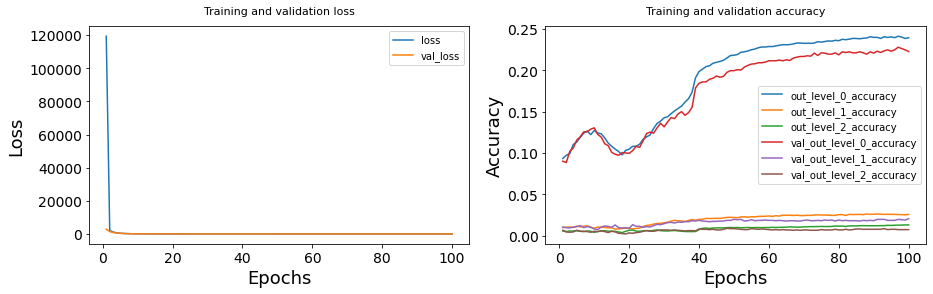

/home/reda/PycharmProjects/Masked-CNN/python3.8_mcnn/lib/python3.8/site-packages/tensorflow/python/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


INFO:tensorflow:Assets written to: models/MLPH_model/assets


In [14]:
# Create the model
MLPH_model = models.get_MLPH_model(num_classes, dataset.image_size)
MLPH_model.summary()
#train model
history_MLPH_model = MLPH_model.fit(dataset.X_train, 
                    dataset.y_train,
                    validation_data = (dataset.X_val, dataset.y_val), 
                    batch_size=batch, 
                    epochs=epochs,
                    callbacks=[performance_callback, early_stopping_callback]
                    )
plot_model(MLPH_model,show_shapes=False, expand_nested=False, dpi=96)
learning_plots(history_MLPH_model)
MLPH_model.save("models/MLPH_model")



Model: "baseline_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
main_input (InputLayer)      [(None, 64, 64, 3)]       0         
_________________________________________________________________
vgg19 (Functional)           (None, None, None, 512)   20024384  
_________________________________________________________________
flatten_11 (Flatten)         (None, 2048)              0         
_________________________________________________________________
output (Dense)               (None, 196)               401604    
Total params: 20,425,988
Trainable params: 20,425,988
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
64/64 [==============================] - 6s 82ms/step - loss: 6.1423 - accuracy: 0.0041 - val_loss: 5.2781 - val_accuracy: 0.0060
------------------------------------------------------------------------------------------------

64/64 [==============================] - 5s 78ms/step - loss: 5.2774 - accuracy: 0.0083 - val_loss: 5.2774 - val_accuracy: 0.0076
----------------------------------------------------------------------------------------------------
epoch=16, Exact Match = 0.0076, accuracy level_0 = 0.0388, accuracy level_1 = 0.0076, accuracy level_2 = 0.0076, Consistency = 1.0000
----------------------------------------------------------------------------------------------------

Epoch 17/100
64/64 [==============================] - 5s 78ms/step - loss: 5.2773 - accuracy: 0.0083 - val_loss: 5.2774 - val_accuracy: 0.0076
----------------------------------------------------------------------------------------------------
epoch=17, Exact Match = 0.0076, accuracy level_0 = 0.0388, accuracy level_1 = 0.0076, accuracy level_2 = 0.0076, Consistency = 1.0000
----------------------------------------------------------------------------------------------------

Epoch 18/100
64/64 [==============================] -

64/64 [==============================] - 5s 78ms/step - loss: 5.2766 - accuracy: 0.0083 - val_loss: 5.2768 - val_accuracy: 0.0076
----------------------------------------------------------------------------------------------------
epoch=33, Exact Match = 0.0076, accuracy level_0 = 0.0388, accuracy level_1 = 0.0076, accuracy level_2 = 0.0076, Consistency = 1.0000
----------------------------------------------------------------------------------------------------

Epoch 34/100
64/64 [==============================] - 5s 78ms/step - loss: 5.2766 - accuracy: 0.0083 - val_loss: 5.2768 - val_accuracy: 0.0076
----------------------------------------------------------------------------------------------------
epoch=34, Exact Match = 0.0076, accuracy level_0 = 0.0388, accuracy level_1 = 0.0076, accuracy level_2 = 0.0076, Consistency = 1.0000
----------------------------------------------------------------------------------------------------

Epoch 35/100
64/64 [==============================] -

64/64 [==============================] - 5s 78ms/step - loss: 5.2760 - accuracy: 0.0083 - val_loss: 5.2763 - val_accuracy: 0.0076
----------------------------------------------------------------------------------------------------
epoch=50, Exact Match = 0.0076, accuracy level_0 = 0.0388, accuracy level_1 = 0.0076, accuracy level_2 = 0.0076, Consistency = 1.0000
----------------------------------------------------------------------------------------------------

Epoch 51/100
64/64 [==============================] - 5s 78ms/step - loss: 5.2760 - accuracy: 0.0083 - val_loss: 5.2762 - val_accuracy: 0.0076
----------------------------------------------------------------------------------------------------
epoch=51, Exact Match = 0.0076, accuracy level_0 = 0.0388, accuracy level_1 = 0.0076, accuracy level_2 = 0.0076, Consistency = 1.0000
----------------------------------------------------------------------------------------------------

Epoch 52/100
64/64 [==============================] -

64/64 [==============================] - 5s 77ms/step - loss: 5.2755 - accuracy: 0.0083 - val_loss: 5.2759 - val_accuracy: 0.0076
----------------------------------------------------------------------------------------------------
epoch=67, Exact Match = 0.0076, accuracy level_0 = 0.0388, accuracy level_1 = 0.0076, accuracy level_2 = 0.0076, Consistency = 1.0000
----------------------------------------------------------------------------------------------------

Epoch 68/100
64/64 [==============================] - 5s 77ms/step - loss: 5.2754 - accuracy: 0.0083 - val_loss: 5.2758 - val_accuracy: 0.0076
----------------------------------------------------------------------------------------------------
epoch=68, Exact Match = 0.0076, accuracy level_0 = 0.0388, accuracy level_1 = 0.0076, accuracy level_2 = 0.0076, Consistency = 1.0000
----------------------------------------------------------------------------------------------------

Epoch 69/100
64/64 [==============================] -

64/64 [==============================] - 5s 77ms/step - loss: 5.2750 - accuracy: 0.0083 - val_loss: 5.2755 - val_accuracy: 0.0076
----------------------------------------------------------------------------------------------------
epoch=84, Exact Match = 0.0076, accuracy level_0 = 0.0388, accuracy level_1 = 0.0076, accuracy level_2 = 0.0076, Consistency = 1.0000
----------------------------------------------------------------------------------------------------

Epoch 85/100
64/64 [==============================] - 5s 79ms/step - loss: 5.2750 - accuracy: 0.0083 - val_loss: 5.2755 - val_accuracy: 0.0076
----------------------------------------------------------------------------------------------------
epoch=85, Exact Match = 0.0076, accuracy level_0 = 0.0388, accuracy level_1 = 0.0076, accuracy level_2 = 0.0076, Consistency = 1.0000
----------------------------------------------------------------------------------------------------

Epoch 86/100
64/64 [==============================] -

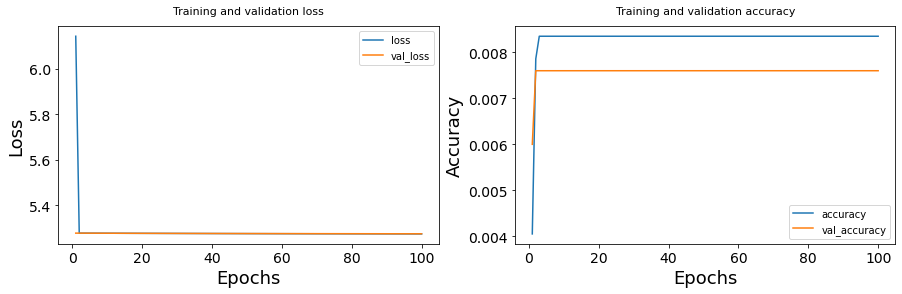

INFO:tensorflow:Assets written to: models/baseline_model/assets


In [15]:
# Create the model
baseline_model = models.get_Baseline_model(num_classes, 
                                           dataset.image_size, 
                                           dataset.taxonomy, 
                                           conv_base=conv_base,
                                           learning_rate=learning_rate)
baseline_model.summary()
#train model
history_baseline_model = baseline_model.fit(dataset.X_train, 
                    dataset.y_train[-1],
                    validation_data = (dataset.X_val, dataset.y_val[-1]),
                    batch_size=batch, 
                    epochs=epochs,
                    callbacks=[performance_callback, early_stopping_callback]
                    )
plot_model(baseline_model)
learning_plots(history_baseline_model)
baseline_model.save("models/baseline_model")


Model: "Masked_Output_Net"
____________________________________________________________________________________________________
Layer (type)                                 Output Shape                            Param #        
main_input (InputLayer)                      [(None, 64, 64, 3)]                     0              
____________________________________________________________________________________________________
vgg19 (Functional)                           (None, None, None, 512)                 20024384       
____________________________________________________________________________________________________
flatten_13 (Flatten)                         (None, 2048)                            0              
____________________________________________________________________________________________________
masked__output_1 (Masked_Output)             [(None, 13), (None, 113), (None, 196)]  659778         
Total params: 20,684,162
Trainable params: 20,684,162
Non-traina

2021-08-27 19:49:37.180677: I tensorflow/core/profiler/lib/profiler_session.cc:126] Profiler session initializing.
2021-08-27 19:49:37.180741: I tensorflow/core/profiler/lib/profiler_session.cc:141] Profiler session started.
2021-08-27 19:49:37.472752: I tensorflow/core/profiler/lib/profiler_session.cc:159] Profiler session tear down.
2021-08-27 19:49:37.472930: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1743] CUPTI activity buffer flushed


Epoch 1/100
 1/64 [..............................] - ETA: 5s - loss: 1.5513 - masked__output_1_loss: 0.7978 - masked__output_1_1_loss: 1.6399 - masked__output_1_2_loss: 2.2163 - masked__output_1_accuracy: 0.6953 - masked__output_1_1_accuracy: 0.6094 - masked__output_1_2_accuracy: 0.5078

2021-08-27 19:49:38.264613: I tensorflow/core/profiler/lib/profiler_session.cc:126] Profiler session initializing.
2021-08-27 19:49:38.264641: I tensorflow/core/profiler/lib/profiler_session.cc:141] Profiler session started.


 2/64 [..............................] - ETA: 22s - loss: 1.4867 - masked__output_1_loss: 0.7558 - masked__output_1_1_loss: 1.5525 - masked__output_1_2_loss: 2.1518 - masked__output_1_accuracy: 0.7148 - masked__output_1_1_accuracy: 0.6445 - masked__output_1_2_accuracy: 0.5547

2021-08-27 19:49:38.626337: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2021-08-27 19:49:38.627594: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1743] CUPTI activity buffer flushed
2021-08-27 19:49:38.781223: I tensorflow/core/profiler/internal/gpu/cupti_collector.cc:673]  GpuTracer has collected 551 callback api events and 543 activity events. 
2021-08-27 19:49:38.792031: I tensorflow/core/profiler/lib/profiler_session.cc:159] Profiler session tear down.
2021-08-27 19:49:38.805148: I tensorflow/core/profiler/rpc/client/save_profile.cc:137] Creating directory: /tmp/logs/train/plugins/profile/2021_08_27_19_49_38
2021-08-27 19:49:38.812900: I tensorflow/core/profiler/rpc/client/save_profile.cc:143] Dumped gzipped tool data for trace.json.gz to /tmp/logs/train/plugins/profile/2021_08_27_19_49_38/reda-ThinkStation-P520.trace.json.gz


 4/64 [>.............................] - ETA: 15s - loss: 1.4011 - masked__output_1_loss: 0.7197 - masked__output_1_1_loss: 1.4495 - masked__output_1_2_loss: 2.0341 - masked__output_1_accuracy: 0.7285 - masked__output_1_1_accuracy: 0.6602 - masked__output_1_2_accuracy: 0.5859

2021-08-27 19:49:38.840998: I tensorflow/core/profiler/rpc/client/save_profile.cc:137] Creating directory: /tmp/logs/train/plugins/profile/2021_08_27_19_49_38
2021-08-27 19:49:38.844698: I tensorflow/core/profiler/rpc/client/save_profile.cc:143] Dumped gzipped tool data for memory_profile.json.gz to /tmp/logs/train/plugins/profile/2021_08_27_19_49_38/reda-ThinkStation-P520.memory_profile.json.gz
2021-08-27 19:49:38.846449: I tensorflow/core/profiler/rpc/client/capture_profile.cc:251] Creating directory: /tmp/logs/train/plugins/profile/2021_08_27_19_49_38Dumped tool data for xplane.pb to /tmp/logs/train/plugins/profile/2021_08_27_19_49_38/reda-ThinkStation-P520.xplane.pb
Dumped tool data for overview_page.pb to /tmp/logs/train/plugins/profile/2021_08_27_19_49_38/reda-ThinkStation-P520.overview_page.pb
Dumped tool data for input_pipeline.pb to /tmp/logs/train/plugins/profile/2021_08_27_19_49_38/reda-ThinkStation-P520.input_pipeline.pb
Dumped tool data for tensorflow_stats.pb to /tmp/logs

64/64 [==============================] - 6s 95ms/step - loss: 1.4581 - masked__output_1_loss: 0.7288 - masked__output_1_1_loss: 1.4987 - masked__output_1_2_loss: 2.1469 - masked__output_1_accuracy: 0.7305 - masked__output_1_1_accuracy: 0.6451 - masked__output_1_2_accuracy: 0.5619 - val_loss: 5.0115 - val_masked__output_1_loss: 3.1015 - val_masked__output_1_1_loss: 5.3721 - val_masked__output_1_2_loss: 6.5608 - val_masked__output_1_accuracy: 0.2996 - val_masked__output_1_1_accuracy: 0.0672 - val_masked__output_1_2_accuracy: 0.0412
----------------------------------------------------------------------------------------------------
epoch=1, Exact Match = 0.0288, accuracy level_0 = 0.2996, accuracy level_1 = 0.0672, accuracy level_2 = 0.0412, Consistency = 0.5896
----------------------------------------------------------------------------------------------------

Epoch 2/100
64/64 [==============================] - 5s 83ms/step - loss: 1.4967 - masked__output_1_loss: 0.7461 - masked__outpu

64/64 [==============================] - 5s 84ms/step - loss: 1.3315 - masked__output_1_loss: 0.6859 - masked__output_1_1_loss: 1.3460 - masked__output_1_2_loss: 1.9627 - masked__output_1_accuracy: 0.7391 - masked__output_1_1_accuracy: 0.6796 - masked__output_1_2_accuracy: 0.6135 - val_loss: 5.1816 - val_masked__output_1_loss: 3.1320 - val_masked__output_1_1_loss: 5.5242 - val_masked__output_1_2_loss: 6.8887 - val_masked__output_1_accuracy: 0.2808 - val_masked__output_1_1_accuracy: 0.0676 - val_masked__output_1_2_accuracy: 0.0412
----------------------------------------------------------------------------------------------------
epoch=10, Exact Match = 0.0304, accuracy level_0 = 0.2808, accuracy level_1 = 0.0676, accuracy level_2 = 0.0412, Consistency = 0.5820
----------------------------------------------------------------------------------------------------

Epoch 11/100
64/64 [==============================] - 5s 84ms/step - loss: 1.3545 - masked__output_1_loss: 0.6982 - masked__out

64/64 [==============================] - 5s 82ms/step - loss: 1.3177 - masked__output_1_loss: 0.6909 - masked__output_1_1_loss: 1.3286 - masked__output_1_2_loss: 1.9336 - masked__output_1_accuracy: 0.7398 - masked__output_1_1_accuracy: 0.6787 - masked__output_1_2_accuracy: 0.6222 - val_loss: 5.2041 - val_masked__output_1_loss: 3.1735 - val_masked__output_1_1_loss: 5.5793 - val_masked__output_1_2_loss: 6.8596 - val_masked__output_1_accuracy: 0.2880 - val_masked__output_1_1_accuracy: 0.0684 - val_masked__output_1_2_accuracy: 0.0416
----------------------------------------------------------------------------------------------------
epoch=19, Exact Match = 0.0284, accuracy level_0 = 0.2880, accuracy level_1 = 0.0684, accuracy level_2 = 0.0416, Consistency = 0.5984
----------------------------------------------------------------------------------------------------

Epoch 20/100
64/64 [==============================] - 5s 83ms/step - loss: 1.2712 - masked__output_1_loss: 0.6818 - masked__out

64/64 [==============================] - 5s 81ms/step - loss: 1.1999 - masked__output_1_loss: 0.6529 - masked__output_1_1_loss: 1.2136 - masked__output_1_2_loss: 1.7330 - masked__output_1_accuracy: 0.7472 - masked__output_1_1_accuracy: 0.7063 - masked__output_1_2_accuracy: 0.6654 - val_loss: 5.2496 - val_masked__output_1_loss: 3.2171 - val_masked__output_1_1_loss: 5.6417 - val_masked__output_1_2_loss: 6.8901 - val_masked__output_1_accuracy: 0.2896 - val_masked__output_1_1_accuracy: 0.0572 - val_masked__output_1_2_accuracy: 0.0400
----------------------------------------------------------------------------------------------------
epoch=28, Exact Match = 0.0260, accuracy level_0 = 0.2896, accuracy level_1 = 0.0576, accuracy level_2 = 0.0400, Consistency = 0.5920
----------------------------------------------------------------------------------------------------

Epoch 29/100
64/64 [==============================] - 5s 82ms/step - loss: 1.2077 - masked__output_1_loss: 0.6544 - masked__out

64/64 [==============================] - 5s 82ms/step - loss: 1.1887 - masked__output_1_loss: 0.6538 - masked__output_1_1_loss: 1.1926 - masked__output_1_2_loss: 1.7199 - masked__output_1_accuracy: 0.7471 - masked__output_1_1_accuracy: 0.7065 - masked__output_1_2_accuracy: 0.6751 - val_loss: 5.2510 - val_masked__output_1_loss: 3.1941 - val_masked__output_1_1_loss: 5.6718 - val_masked__output_1_2_loss: 6.8871 - val_masked__output_1_accuracy: 0.2968 - val_masked__output_1_1_accuracy: 0.0732 - val_masked__output_1_2_accuracy: 0.0456
----------------------------------------------------------------------------------------------------
epoch=37, Exact Match = 0.0328, accuracy level_0 = 0.2968, accuracy level_1 = 0.0732, accuracy level_2 = 0.0456, Consistency = 0.6132
----------------------------------------------------------------------------------------------------

Epoch 38/100
64/64 [==============================] - 5s 83ms/step - loss: 1.1576 - masked__output_1_loss: 0.6340 - masked__out

64/64 [==============================] - 5s 83ms/step - loss: 1.1627 - masked__output_1_loss: 0.6444 - masked__output_1_1_loss: 1.1688 - masked__output_1_2_loss: 1.6747 - masked__output_1_accuracy: 0.7485 - masked__output_1_1_accuracy: 0.7116 - masked__output_1_2_accuracy: 0.6805 - val_loss: 5.4468 - val_masked__output_1_loss: 3.3201 - val_masked__output_1_1_loss: 5.9213 - val_masked__output_1_2_loss: 7.0991 - val_masked__output_1_accuracy: 0.2940 - val_masked__output_1_1_accuracy: 0.0648 - val_masked__output_1_2_accuracy: 0.0408
----------------------------------------------------------------------------------------------------
epoch=46, Exact Match = 0.0284, accuracy level_0 = 0.2940, accuracy level_1 = 0.0648, accuracy level_2 = 0.0408, Consistency = 0.6208
----------------------------------------------------------------------------------------------------

Epoch 47/100
64/64 [==============================] - 5s 82ms/step - loss: 1.1576 - masked__output_1_loss: 0.6361 - masked__out

64/64 [==============================] - 5s 82ms/step - loss: 1.1111 - masked__output_1_loss: 0.6232 - masked__output_1_1_loss: 1.1165 - masked__output_1_2_loss: 1.5936 - masked__output_1_accuracy: 0.7555 - masked__output_1_1_accuracy: 0.7231 - masked__output_1_2_accuracy: 0.6994 - val_loss: 5.4901 - val_masked__output_1_loss: 3.4589 - val_masked__output_1_1_loss: 5.9819 - val_masked__output_1_2_loss: 7.0295 - val_masked__output_1_accuracy: 0.2828 - val_masked__output_1_1_accuracy: 0.0636 - val_masked__output_1_2_accuracy: 0.0412
----------------------------------------------------------------------------------------------------
epoch=55, Exact Match = 0.0320, accuracy level_0 = 0.2828, accuracy level_1 = 0.0632, accuracy level_2 = 0.0412, Consistency = 0.6224
----------------------------------------------------------------------------------------------------

Epoch 56/100
64/64 [==============================] - 5s 83ms/step - loss: 1.1186 - masked__output_1_loss: 0.6240 - masked__out

64/64 [==============================] - 5s 82ms/step - loss: 1.1699 - masked__output_1_loss: 0.6561 - masked__output_1_1_loss: 1.1776 - masked__output_1_2_loss: 1.6760 - masked__output_1_accuracy: 0.7468 - masked__output_1_1_accuracy: 0.7114 - masked__output_1_2_accuracy: 0.6890 - val_loss: 5.3747 - val_masked__output_1_loss: 3.3421 - val_masked__output_1_1_loss: 5.8828 - val_masked__output_1_2_loss: 6.8992 - val_masked__output_1_accuracy: 0.2884 - val_masked__output_1_1_accuracy: 0.0624 - val_masked__output_1_2_accuracy: 0.0336
----------------------------------------------------------------------------------------------------
epoch=64, Exact Match = 0.0256, accuracy level_0 = 0.2884, accuracy level_1 = 0.0620, accuracy level_2 = 0.0336, Consistency = 0.6352
----------------------------------------------------------------------------------------------------

Epoch 65/100
64/64 [==============================] - 5s 82ms/step - loss: 1.1904 - masked__output_1_loss: 0.6610 - masked__out

64/64 [==============================] - 5s 83ms/step - loss: 1.0409 - masked__output_1_loss: 0.5938 - masked__output_1_1_loss: 1.0357 - masked__output_1_2_loss: 1.4932 - masked__output_1_accuracy: 0.7593 - masked__output_1_1_accuracy: 0.7371 - masked__output_1_2_accuracy: 0.7215 - val_loss: 5.3371 - val_masked__output_1_loss: 3.3247 - val_masked__output_1_1_loss: 5.9271 - val_masked__output_1_2_loss: 6.7595 - val_masked__output_1_accuracy: 0.2896 - val_masked__output_1_1_accuracy: 0.0688 - val_masked__output_1_2_accuracy: 0.0420
----------------------------------------------------------------------------------------------------
epoch=73, Exact Match = 0.0296, accuracy level_0 = 0.2900, accuracy level_1 = 0.0680, accuracy level_2 = 0.0420, Consistency = 0.5964
----------------------------------------------------------------------------------------------------

Epoch 74/100
64/64 [==============================] - 5s 83ms/step - loss: 1.0570 - masked__output_1_loss: 0.5992 - masked__out

64/64 [==============================] - 5s 83ms/step - loss: 1.0975 - masked__output_1_loss: 0.6180 - masked__output_1_1_loss: 1.0977 - masked__output_1_2_loss: 1.5767 - masked__output_1_accuracy: 0.7569 - masked__output_1_1_accuracy: 0.7275 - masked__output_1_2_accuracy: 0.7094 - val_loss: 5.5074 - val_masked__output_1_loss: 3.4886 - val_masked__output_1_1_loss: 6.0844 - val_masked__output_1_2_loss: 6.9493 - val_masked__output_1_accuracy: 0.2776 - val_masked__output_1_1_accuracy: 0.0656 - val_masked__output_1_2_accuracy: 0.0364
----------------------------------------------------------------------------------------------------
epoch=82, Exact Match = 0.0256, accuracy level_0 = 0.2788, accuracy level_1 = 0.0664, accuracy level_2 = 0.0364, Consistency = 0.6284
----------------------------------------------------------------------------------------------------

Epoch 83/100
64/64 [==============================] - 5s 83ms/step - loss: 1.1207 - masked__output_1_loss: 0.6315 - masked__out

64/64 [==============================] - 5s 82ms/step - loss: 1.0511 - masked__output_1_loss: 0.5933 - masked__output_1_1_loss: 1.0464 - masked__output_1_2_loss: 1.5135 - masked__output_1_accuracy: 0.7615 - masked__output_1_1_accuracy: 0.7340 - masked__output_1_2_accuracy: 0.7192 - val_loss: 5.5106 - val_masked__output_1_loss: 3.4516 - val_masked__output_1_1_loss: 6.2568 - val_masked__output_1_2_loss: 6.8232 - val_masked__output_1_accuracy: 0.2908 - val_masked__output_1_1_accuracy: 0.0644 - val_masked__output_1_2_accuracy: 0.0388
----------------------------------------------------------------------------------------------------
epoch=91, Exact Match = 0.0256, accuracy level_0 = 0.2908, accuracy level_1 = 0.0640, accuracy level_2 = 0.0388, Consistency = 0.6356
----------------------------------------------------------------------------------------------------

Epoch 92/100
64/64 [==============================] - 5s 82ms/step - loss: 1.0464 - masked__output_1_loss: 0.5998 - masked__out

64/64 [==============================] - 5s 81ms/step - loss: 4.0165 - masked__output_1_loss: 2.2331 - masked__output_1_1_loss: 4.5594 - masked__output_1_2_loss: 5.2570 - masked__output_1_accuracy: 0.2687 - masked__output_1_1_accuracy: 0.0320 - masked__output_1_2_accuracy: 0.0072 - val_loss: 4.0058 - val_masked__output_1_loss: 2.2291 - val_masked__output_1_1_loss: 4.5325 - val_masked__output_1_2_loss: 5.2558 - val_masked__output_1_accuracy: 0.2632 - val_masked__output_1_1_accuracy: 0.0260 - val_masked__output_1_2_accuracy: 0.0100
----------------------------------------------------------------------------------------------------
epoch=100, Exact Match = 0.0036, accuracy level_0 = 0.2632, accuracy level_1 = 0.0260, accuracy level_2 = 0.0100, Consistency = 0.3828
----------------------------------------------------------------------------------------------------



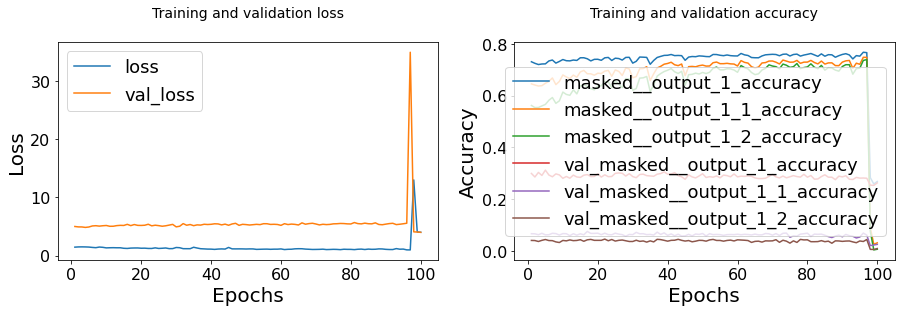

INFO:tensorflow:Assets written to: models/mcnn_model/assets


In [32]:
# Create the model
mcnn_model = models.get_Masked_Output_Net(num_classes,
                                          dataset.image_size,
                                          dataset.taxonomy,
                                          conv_base=conv_base,
                                          learning_rate=1e-3)
mcnn_model.summary(line_length=100)

tensorboard = TensorBoard(log_dir='/tmp/logs', histogram_freq=0,
                          write_graph=True, write_images=False)

#train model
history_mcnn_model_model = mcnn_model.fit(dataset.X_train, 
                    dataset.y_train,
                    validation_data = (dataset.X_val, dataset.y_val), 
                    batch_size=batch, 
                    epochs=100,
                    callbacks=[performance_callback, tensorboard]
                    )
plot_model(mcnn_model)
learning_plots(history_mcnn_model_model)
mcnn_model.save("models/mcnn_model")


In [30]:
mcnn_model_pred = mcnn_model.predict(dataset.X_test)



In [31]:
print(metrics.get_h_accuracy(dataset.y_test, mcnn_model_pred, k=2))
print(metrics.get_h_accuracy(dataset.y_test, mcnn_model_pred, k=3))
print(metrics.get_h_accuracy(dataset.y_test, mcnn_model_pred, k=4))
print(metrics.get_h_accuracy(dataset.y_test, mcnn_model_pred, k=5))
print(metrics.get_h_accuracy(dataset.y_test, mcnn_model_pred, k=6))
print(metrics.get_h_accuracy(dataset.y_test, mcnn_model_pred, k=7))
print(metrics.get_h_accuracy(dataset.y_test, mcnn_model_pred, k=8))
print(metrics.get_h_accuracy(dataset.y_test, mcnn_model_pred, k=9))
print(metrics.get_h_accuracy(dataset.y_test, mcnn_model_pred, k=10))


0.11424096619775959
0.15497009473139733
0.19008535357975131
0.21882930948227175
0.24701893012072468
0.27128242499106103
0.2939251578742126
0.31622363513018803
0.3363230130586424


In [28]:
print(metrics.get_h_accuracy(dataset.y_test, BCNN2_reversed_pred, k=2))
print(metrics.get_h_accuracy(dataset.y_test, BCNN2_reversed_pred, k=3))
print(metrics.get_h_accuracy(dataset.y_test, BCNN2_reversed_pred, k=4))
print(metrics.get_h_accuracy(dataset.y_test, BCNN2_reversed_pred, k=5))
print(metrics.get_h_accuracy(dataset.y_test, BCNN2_reversed_pred, k=6))
print(metrics.get_h_accuracy(dataset.y_test, BCNN2_reversed_pred, k=7))
print(metrics.get_h_accuracy(dataset.y_test, BCNN2_reversed_pred, k=8))
print(metrics.get_h_accuracy(dataset.y_test, BCNN2_reversed_pred, k=9))
print(metrics.get_h_accuracy(dataset.y_test, BCNN2_reversed_pred, k=10))


0.27823549521015306
0.34992086940313905
0.4064843211549638
0.45233772804090217
0.4882069111107505
0.5186221333452278
0.548827438267378
0.5729623466299871
0.5963241815558047


In [17]:
# Make predictions on the test set
mout_pred = mout_model.predict(dataset.X_test)
BCNN1_pred = BCNN1_model.predict(dataset.X_test)
BCNN1_reversed_pred = BCNN1_reversed_model.predict(dataset.X_test)
BCNN2_pred = BCNN2_model.predict(dataset.X_test)
BCNN2_reversed_pred = BCNN2_reversed_model.predict(dataset.X_test)
mnets_pred = mnets_model.predict(dataset.X_test)
baseline_pred = baseline_model.predict(dataset.X_test)
MLPH_pred = MLPH_model.predict(dataset.X_test)
mcnn_pred = mcnn_model.predict(dataset.X_test)


In [18]:
exact_match_scores = [metrics.get_exact_match(dataset.y_test, mout_pred),
                      metrics.get_exact_match(dataset.y_test, BCNN1_pred),
                      metrics.get_exact_match(dataset.y_test, BCNN1_reversed_pred),
                      metrics.get_exact_match(dataset.y_test, BCNN2_pred),
                      metrics.get_exact_match(dataset.y_test, BCNN2_reversed_pred),
                      metrics.get_exact_match(dataset.y_test, mnets_pred),
                      metrics.get_exact_match(dataset.y_test, baseline_pred),
                      metrics.get_exact_match(dataset.y_test, MLPH_pred),
                      metrics.get_exact_match(dataset.y_test, mcnn_pred)]

h_accuracy_scores = [metrics.get_h_accuracy(dataset.y_test, mout_pred),
                     metrics.get_h_accuracy(dataset.y_test, BCNN1_pred),
                     metrics.get_h_accuracy(dataset.y_test, BCNN1_reversed_pred),
                     metrics.get_h_accuracy(dataset.y_test, BCNN2_pred),
                     metrics.get_h_accuracy(dataset.y_test, BCNN2_reversed_pred),
                     metrics.get_h_accuracy(dataset.y_test, mnets_pred),
                     metrics.get_h_accuracy(dataset.y_test, baseline_pred), 
                     metrics.get_h_accuracy(dataset.y_test, MLPH_pred), 
                     metrics.get_h_accuracy(dataset.y_test, mcnn_pred)]

h_accuracy_scores_k2 = [metrics.get_h_accuracy(dataset.y_test, mout_pred, k=2),
                     metrics.get_h_accuracy(dataset.y_test, BCNN1_pred, k=2),
                     metrics.get_h_accuracy(dataset.y_test, BCNN1_reversed_pred, k=2),
                     metrics.get_h_accuracy(dataset.y_test, BCNN2_pred, k=2),
                     metrics.get_h_accuracy(dataset.y_test, BCNN2_reversed_pred, k=2),
                     metrics.get_h_accuracy(dataset.y_test, mnets_pred, k=2),
                     metrics.get_h_accuracy(dataset.y_test, baseline_pred, k=2), 
                     metrics.get_h_accuracy(dataset.y_test, MLPH_pred, k=2), 
                     metrics.get_h_accuracy(dataset.y_test, mcnn_pred, k=2)]

h_accuracy_scores_k5 = [metrics.get_h_accuracy(dataset.y_test, mout_pred, k=5),
                     metrics.get_h_accuracy(dataset.y_test, BCNN1_pred, k=5),
                     metrics.get_h_accuracy(dataset.y_test, BCNN1_reversed_pred, k=5),
                     metrics.get_h_accuracy(dataset.y_test, BCNN2_pred, k=5),
                     metrics.get_h_accuracy(dataset.y_test, BCNN2_reversed_pred, k=5),
                     metrics.get_h_accuracy(dataset.y_test, mnets_pred, k=5),
                     metrics.get_h_accuracy(dataset.y_test, baseline_pred, k=5), 
                     metrics.get_h_accuracy(dataset.y_test, MLPH_pred, k=5), 
                     metrics.get_h_accuracy(dataset.y_test, mcnn_pred, k=5)]

m_accuracy_scores = [metrics.get_m_accuracy(dataset.y_test, mout_pred),
                     metrics.get_m_accuracy(dataset.y_test, BCNN1_pred),
                     metrics.get_m_accuracy(dataset.y_test, BCNN1_reversed_pred),
                     metrics.get_m_accuracy(dataset.y_test, BCNN2_pred),
                     metrics.get_m_accuracy(dataset.y_test, BCNN2_reversed_pred),
                     metrics.get_m_accuracy(dataset.y_test, mnets_pred),
                     metrics.get_m_accuracy(dataset.y_test, baseline_pred),
                     metrics.get_m_accuracy(dataset.y_test, MLPH_pred),
                     metrics.get_m_accuracy(dataset.y_test, mcnn_pred)]


consistency = [metrics.get_consistency(mout_pred, dataset.taxonomy),
               metrics.get_consistency(BCNN1_pred, dataset.taxonomy),
               metrics.get_consistency(BCNN1_reversed_pred, dataset.taxonomy),
               metrics.get_consistency(BCNN2_pred, dataset.taxonomy),
               metrics.get_consistency(BCNN2_reversed_pred, dataset.taxonomy),
               metrics.get_consistency(mnets_pred, dataset.taxonomy),
               metrics.get_consistency(baseline_pred, dataset.taxonomy),
               metrics.get_consistency(MLPH_pred, dataset.taxonomy),
               metrics.get_consistency(mcnn_pred, dataset.taxonomy)]

# Create example dataframe
df = pd.DataFrame({
'exact_match': exact_match_scores,
'h_accuracy': h_accuracy_scores,
'h_accuracy_k2': h_accuracy_scores_k2,
'h_accuracy_k5': h_accuracy_scores_k5,
'm_accuracy': m_accuracy_scores,
'consistency': consistency,
's': [3000,3000,3000,3000,3000,3000,3000,3000,3000],
'algo': ['mout','BCNN1','BCNN1_R','BCNN2','BCNN2_R', 'mnets', 'baseline', 'MLPH', 'M-CNN']
})


/home/reda/PycharmProjects/Masked-CNN/python3.8_mcnn/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


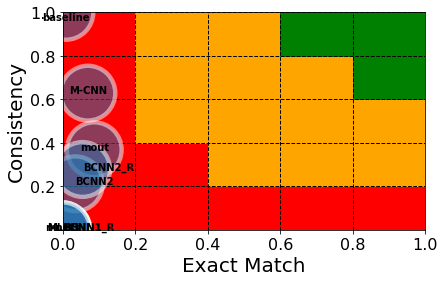

In [19]:
plt.figure(figsize=(6.5, 4))
params = {'legend.fontsize': 18,
          'axes.labelsize': 20,
          'axes.titlesize': 14,
          'xtick.labelsize': 16,
          'ytick.labelsize': 16,
          'axes.titlepad': 25,
          'font.size': 10}
plt.rcParams.update(params)

ax = sns.scatterplot(df.exact_match, df.consistency, alpha = 0.5,s = df.s)

ax.grid(color='black', linestyle='--', linewidth=1)
ax.set_axisbelow(True)

plt.xlabel("")
plt.ylabel("consistency")
# plt.title("Box plot of #candidates per cycle and system")
plt.yticks([0.2,0.4,0.6,0.8,1.0])
plt.xticks([0.0,0.2,0.4,0.6,0.8,1.0])

ax.set_xlim(0,1)
ax.set_ylim(0, 1)
plt.xlabel('Exact Match')
plt.ylabel('Consistency')
#For each point, we add a text inside the bubble
for line in range(0,df.shape[0]):
    if df.algo[line]=='baseline':
        ax.text(df.exact_match[line], df.consistency[line], df.algo[line], verticalalignment='top', horizontalalignment='center', size='medium', color='black', weight='semibold')
    elif df.algo[line].startswith('BCNN'):
        ax.text(df.exact_match[line], df.consistency[line], df.algo[line], horizontalalignment='left', size='medium', color='black', weight='semibold')
    else:
        ax.text(df.exact_match[line], df.consistency[line], df.algo[line], horizontalalignment='center', size='medium', color='black', weight='semibold')



currentAxis = plt.gca()
currentAxis.add_patch(Rectangle((0., 0.), 1., 0.2, color = 'red', zorder=0))
currentAxis.add_patch(Rectangle((0., 0.), .2, 1., color = 'red',zorder=0))
currentAxis.add_patch(Rectangle((0.2, 0.2), 0.2, 0.2, color = 'red', zorder=0))

currentAxis.add_patch(Rectangle((0.2, 0.4), 0.4, 1.0, color = 'orange', zorder=0))
currentAxis.add_patch(Rectangle((0.4, 0.2), 1., 0.4, color = 'orange', zorder=0))
currentAxis.add_patch(Rectangle((0.6, 0.6), 0.2, 0.2, color = 'orange', zorder=0))

currentAxis.add_patch(Rectangle((0.8, 0.6), 0.2, 0.4, color = 'green', zorder=0))
currentAxis.add_patch(Rectangle((0.6, 0.8), 0.4, 0.2, color = 'green', zorder=0))
# plotlim = plt.xlim() + plt.ylim()
# import matplotlib.colors

# cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", ["red","yellow","green"])

# ax.imshow([[0.5, 0.5, 0.5], [0, 0.5, 0.5], [0, 0, 0.5]],
#           cmap=cmap,
#           interpolation='bicubic',
#           extent=plotlim, vmin=0, vmax=0.5)
        
plt.savefig('plots/bubble_plot_em.pdf', bbox_inches = 'tight')
plt.show()


/home/reda/PycharmProjects/Masked-CNN/python3.8_mcnn/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


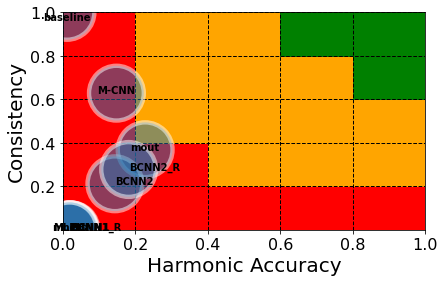

In [20]:
plt.figure(figsize=(6.5, 4))
params = {'legend.fontsize': 18,
          'axes.labelsize': 20,
          'axes.titlesize': 14,
          'xtick.labelsize': 16,
          'ytick.labelsize': 16,
          'axes.titlepad': 25,
          'font.size': 10}
plt.rcParams.update(params)

ax = sns.scatterplot(df.h_accuracy, df.consistency, alpha = 0.5,s = df.s)

ax.grid(color='black', linestyle='--', linewidth=1)
ax.set_axisbelow(True)

plt.xlabel("")
plt.ylabel("consistency")
# plt.title("Box plot of #candidates per cycle and system")
plt.yticks([0.2,0.4,0.6,0.8,1.0])
plt.xticks([0.0,0.2,0.4,0.6,0.8,1.0])

ax.set_xlim(0,1)
ax.set_ylim(0, 1)
plt.xlabel('Harmonic Accuracy')
plt.ylabel('Consistency')
#For each point, we add a text inside the bubble
for line in range(0,df.shape[0]):
    if df.algo[line]=='baseline':
        ax.text(df.h_accuracy[line], df.consistency[line], df.algo[line], verticalalignment='top', horizontalalignment='center', size='medium', color='black', weight='semibold')
    elif df.algo[line].startswith('BCNN'):
        ax.text(df.h_accuracy[line], df.consistency[line], df.algo[line], horizontalalignment='left', size='medium', color='black', weight='semibold')
    else:
        ax.text(df.h_accuracy[line], df.consistency[line], df.algo[line], horizontalalignment='center', size='medium', color='black', weight='semibold')



currentAxis = plt.gca()
currentAxis.add_patch(Rectangle((0., 0.), 1., 0.2, color = 'red', zorder=0))
currentAxis.add_patch(Rectangle((0., 0.), .2, 1., color = 'red',zorder=0))
currentAxis.add_patch(Rectangle((0.2, 0.2), 0.2, 0.2, color = 'red', zorder=0))

currentAxis.add_patch(Rectangle((0.2, 0.4), 0.4, 1.0, color = 'orange', zorder=0))
currentAxis.add_patch(Rectangle((0.4, 0.2), 1., 0.4, color = 'orange', zorder=0))
currentAxis.add_patch(Rectangle((0.6, 0.6), 0.2, 0.2, color = 'orange', zorder=0))

currentAxis.add_patch(Rectangle((0.8, 0.6), 0.2, 0.4, color = 'green', zorder=0))
currentAxis.add_patch(Rectangle((0.6, 0.8), 0.4, 0.2, color = 'green', zorder=0))
# plotlim = plt.xlim() + plt.ylim()
# import matplotlib.colors

# cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", ["red","yellow","green"])

# ax.imshow([[0.5, 0.5, 0.5], [0, 0.5, 0.5], [0, 0, 0.5]],
#           cmap=cmap,
#           interpolation='bicubic',
#           extent=plotlim, vmin=0, vmax=0.5)
        
plt.savefig('plots/bubble_plot_h_accuracy.pdf', bbox_inches = 'tight')
plt.show()


/home/reda/PycharmProjects/Masked-CNN/python3.8_mcnn/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


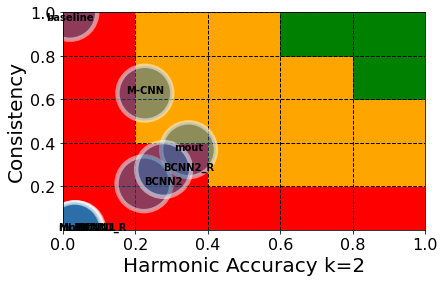

In [21]:
plt.figure(figsize=(6.5, 4))
params = {'legend.fontsize': 18,
          'axes.labelsize': 20,
          'axes.titlesize': 14,
          'xtick.labelsize': 16,
          'ytick.labelsize': 16,
          'axes.titlepad': 25,
          'font.size': 10}
plt.rcParams.update(params)

ax = sns.scatterplot(df.h_accuracy_k2, df.consistency, alpha = 0.5,s = df.s)

ax.grid(color='black', linestyle='--', linewidth=1)
ax.set_axisbelow(True)

plt.xlabel("")
plt.ylabel("consistency")
# plt.title("Box plot of #candidates per cycle and system")
plt.yticks([0.2,0.4,0.6,0.8,1.0])
plt.xticks([0.0,0.2,0.4,0.6,0.8,1.0])

ax.set_xlim(0,1)
ax.set_ylim(0, 1)
plt.xlabel('Harmonic Accuracy k=2')
plt.ylabel('Consistency')
#For each point, we add a text inside the bubble
for line in range(0,df.shape[0]):
    if df.algo[line]=='baseline':
        ax.text(df.h_accuracy_k2[line], df.consistency[line], df.algo[line], verticalalignment='top', horizontalalignment='center', size='medium', color='black', weight='semibold')
    elif df.algo[line].startswith('BCNN'):
        ax.text(df.h_accuracy_k2[line], df.consistency[line], df.algo[line], horizontalalignment='left', size='medium', color='black', weight='semibold')
    else:
        ax.text(df.h_accuracy_k2[line], df.consistency[line], df.algo[line], horizontalalignment='center', size='medium', color='black', weight='semibold')



currentAxis = plt.gca()
currentAxis.add_patch(Rectangle((0., 0.), 1., 0.2, color = 'red', zorder=0))
currentAxis.add_patch(Rectangle((0., 0.), .2, 1., color = 'red',zorder=0))
currentAxis.add_patch(Rectangle((0.2, 0.2), 0.2, 0.2, color = 'red', zorder=0))

currentAxis.add_patch(Rectangle((0.2, 0.4), 0.4, 1.0, color = 'orange', zorder=0))
currentAxis.add_patch(Rectangle((0.4, 0.2), 1., 0.4, color = 'orange', zorder=0))
currentAxis.add_patch(Rectangle((0.6, 0.6), 0.2, 0.2, color = 'orange', zorder=0))

currentAxis.add_patch(Rectangle((0.8, 0.6), 0.2, 0.4, color = 'green', zorder=0))
currentAxis.add_patch(Rectangle((0.6, 0.8), 0.4, 0.2, color = 'green', zorder=0))
# plotlim = plt.xlim() + plt.ylim()
# import matplotlib.colors

# cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", ["red","yellow","green"])

# ax.imshow([[0.5, 0.5, 0.5], [0, 0.5, 0.5], [0, 0, 0.5]],
#           cmap=cmap,
#           interpolation='bicubic',
#           extent=plotlim, vmin=0, vmax=0.5)
        
plt.savefig('plots/bubble_plot_h_accuracy_k2.pdf', bbox_inches = 'tight')
plt.show()


/home/reda/PycharmProjects/Masked-CNN/python3.8_mcnn/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


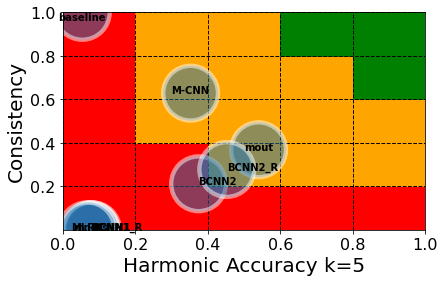

In [22]:
plt.figure(figsize=(6.5, 4))
params = {'legend.fontsize': 18,
          'axes.labelsize': 20,
          'axes.titlesize': 14,
          'xtick.labelsize': 16,
          'ytick.labelsize': 16,
          'axes.titlepad': 25,
          'font.size': 10}
plt.rcParams.update(params)

ax = sns.scatterplot(df.h_accuracy_k5, df.consistency, alpha = 0.5,s = df.s)

ax.grid(color='black', linestyle='--', linewidth=1)
ax.set_axisbelow(True)

plt.xlabel("")
plt.ylabel("consistency")
# plt.title("Box plot of #candidates per cycle and system")
plt.yticks([0.2,0.4,0.6,0.8,1.0])
plt.xticks([0.0,0.2,0.4,0.6,0.8,1.0])

ax.set_xlim(0,1)
ax.set_ylim(0, 1)
plt.xlabel('Harmonic Accuracy k=5')
plt.ylabel('Consistency')
#For each point, we add a text inside the bubble
for line in range(0,df.shape[0]):
    if df.algo[line]=='baseline':
        ax.text(df.h_accuracy_k5[line], df.consistency[line], df.algo[line], verticalalignment='top', horizontalalignment='center', size='medium', color='black', weight='semibold')
    elif df.algo[line].startswith('BCNN'):
        ax.text(df.h_accuracy_k5[line], df.consistency[line], df.algo[line], horizontalalignment='left', size='medium', color='black', weight='semibold')
    else:
        ax.text(df.h_accuracy_k5[line], df.consistency[line], df.algo[line], horizontalalignment='center', size='medium', color='black', weight='semibold')



currentAxis = plt.gca()
currentAxis.add_patch(Rectangle((0., 0.), 1., 0.2, color = 'red', zorder=0))
currentAxis.add_patch(Rectangle((0., 0.), .2, 1., color = 'red',zorder=0))
currentAxis.add_patch(Rectangle((0.2, 0.2), 0.2, 0.2, color = 'red', zorder=0))

currentAxis.add_patch(Rectangle((0.2, 0.4), 0.4, 1.0, color = 'orange', zorder=0))
currentAxis.add_patch(Rectangle((0.4, 0.2), 1., 0.4, color = 'orange', zorder=0))
currentAxis.add_patch(Rectangle((0.6, 0.6), 0.2, 0.2, color = 'orange', zorder=0))

currentAxis.add_patch(Rectangle((0.8, 0.6), 0.2, 0.4, color = 'green', zorder=0))
currentAxis.add_patch(Rectangle((0.6, 0.8), 0.4, 0.2, color = 'green', zorder=0))
# plotlim = plt.xlim() + plt.ylim()
# import matplotlib.colors

# cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", ["red","yellow","green"])

# ax.imshow([[0.5, 0.5, 0.5], [0, 0.5, 0.5], [0, 0, 0.5]],
#           cmap=cmap,
#           interpolation='bicubic',
#           extent=plotlim, vmin=0, vmax=0.5)
        
plt.savefig('plots/bubble_plot_h_accuracy_k5.pdf', bbox_inches = 'tight')
plt.show()


/home/reda/PycharmProjects/Masked-CNN/python3.8_mcnn/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


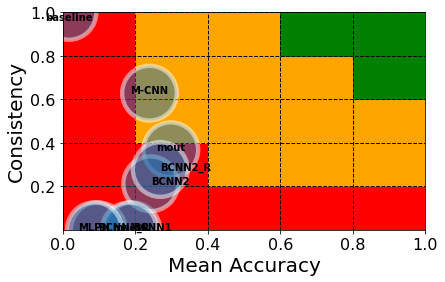

In [23]:
plt.figure(figsize=(6.5, 4))
params = {'legend.fontsize': 18,
          'axes.labelsize': 20,
          'axes.titlesize': 14,
          'xtick.labelsize': 16,
          'ytick.labelsize': 16,
          'axes.titlepad': 25,
          'font.size': 10}
plt.rcParams.update(params)

ax = sns.scatterplot(df.m_accuracy, df.consistency, alpha = 0.5,s = df.s)

ax.grid(color='black', linestyle='--', linewidth=1)
ax.set_axisbelow(True)

plt.xlabel("")
plt.ylabel("consistency")
# plt.title("Box plot of #candidates per cycle and system")
plt.yticks([0.2,0.4,0.6,0.8,1.0])
plt.xticks([0.0,0.2,0.4,0.6,0.8,1.0])

ax.set_xlim(0,1)
ax.set_ylim(0, 1)
plt.xlabel('Mean Accuracy')
plt.ylabel('Consistency')
#For each point, we add a text inside the bubble
for line in range(0,df.shape[0]):
    if df.algo[line]=='baseline':
        ax.text(df.m_accuracy[line], df.consistency[line], df.algo[line], verticalalignment='top', horizontalalignment='center', size='medium', color='black', weight='semibold')
    elif df.algo[line].startswith('BCNN'):
        ax.text(df.m_accuracy[line], df.consistency[line], df.algo[line], horizontalalignment='left', size='medium', color='black', weight='semibold')
    else:
        ax.text(df.m_accuracy[line], df.consistency[line], df.algo[line], horizontalalignment='center', size='medium', color='black', weight='semibold')



currentAxis = plt.gca()
currentAxis.add_patch(Rectangle((0., 0.), 1., 0.2, color = 'red', zorder=0))
currentAxis.add_patch(Rectangle((0., 0.), .2, 1., color = 'red',zorder=0))
currentAxis.add_patch(Rectangle((0.2, 0.2), 0.2, 0.2, color = 'red', zorder=0))

currentAxis.add_patch(Rectangle((0.2, 0.4), 0.4, 1.0, color = 'orange', zorder=0))
currentAxis.add_patch(Rectangle((0.4, 0.2), 1., 0.4, color = 'orange', zorder=0))
currentAxis.add_patch(Rectangle((0.6, 0.6), 0.2, 0.2, color = 'orange', zorder=0))

currentAxis.add_patch(Rectangle((0.8, 0.6), 0.2, 0.4, color = 'green', zorder=0))
currentAxis.add_patch(Rectangle((0.6, 0.8), 0.4, 0.2, color = 'green', zorder=0))
# plotlim = plt.xlim() + plt.ylim()
# import matplotlib.colors

# cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", ["red","yellow","green"])

# ax.imshow([[0.5, 0.5, 0.5], [0, 0.5, 0.5], [0, 0, 0.5]],
#           cmap=cmap,
#           interpolation='bicubic',
#           extent=plotlim, vmin=0, vmax=0.5)
        
plt.savefig('plots/bubble_plot_m_accuracy.pdf', bbox_inches = 'tight')
plt.show()
